# Spark Setup & Imports

In [ ]:
# Author: Brandon Attai

from google.colab import drive
drive.mount('/content/drive/')

#Install Spark and SparkNLP
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

#Install Dependencies
!pip install pyspellchecker==0.5.5
!pip install bs4
!pip install nltk
!pip install twokenize
!pip install demoji
!pip install sparknlp

#Start Spark Session
import sparknlp
spark = sparknlp.start(memory="16G")
# spark = sparknlp.SparkSession.builder.master("local")\
#         .appName("Colab")\
#         .config("spark.sql.broadcastTimeout", "36000")\
#         .getOrCreate()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Mounted at /content/drive/
--2021-12-13 19:50:21--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-12-13 19:50:21--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-12-13 19:50:21--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconte

In [ ]:
# Author: Kelten Falez
#Import Required Libraries
import numpy as np
import datetime
import pandas as pd
from spellchecker import SpellChecker
from bs4 import BeautifulSoup
import re
import demoji
import twokenize
import math
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pyspark.sql.functions as F
import pyspark.sql.types as Types
from pyspark.sql import DataFrame
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, udf, rand
from pyspark.sql.functions import monotonically_increasing_id
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml import Pipeline
from sparknlp import DocumentAssembler, Finisher
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import HashingTF,IDF
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from sparknlp.annotator import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Loading The Data

In [ ]:
# Author: Tahsin Chowdhury

df = spark.read.csv('drive/MyDrive/UofC/Fall 2021/ENSF612/ENSF612-project/ENSF612-Project-2/data_gathering/FINAL_DATASETS/FINAL_DATASET.csv', header="true", inferSchema="true", multiLine= "true", escape='"')
df = df.drop(col("_c0"))


original_df = df.collect()[0:30000]
new_df = df.collect()[30000:]
original_df = spark.createDataFrame(original_df)
new_df = spark.createDataFrame(new_df)


# Data Preprocessing

In [ ]:
#Custom Transformers

class CustomTransformer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
  # Author: Brandon Attai 
  input_col = Param(Params._dummy(), "input_col", "input column name.", typeConverter=TypeConverters.toString)
  output_col = Param(Params._dummy(), "output_col", "output column name.", typeConverter=TypeConverters.toString)
  
  @keyword_only
  def __init__(self, input_col: str = "input", output_col: str = "output"):
    super(CustomTransformer, self).__init__()
    self._setDefault(input_col=None, output_col=None)
    kwargs = self._input_kwargs
    self.set_params(**kwargs)
    
  @keyword_only
  def set_params(self, input_col: str = "input", output_col: str = "output"):
    kwargs = self._input_kwargs
    self._set(**kwargs)
    
  def get_input_col(self):
    return self.getOrDefault(self.input_col)
  
  def get_output_col(self):
    return self.getOrDefault(self.output_col)
  

  def _transform(self, df: DataFrame):

    def process_URLs(text):
      # Author: Tahsin Chowdhury
      return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", text)
    
    def keep_alphabets_lower(text):
      # Author: Kelten Falez
      cleaned_text = re.sub(r"[^a-zA-Z0-9]", " ", text)
      cleaned_text = re.sub(r'[0-9]+', '', cleaned_text)
      cleaned_text = re.sub(' +', ' ', cleaned_text)
      return cleaned_text.lower()

    def fix_spellings(text):
      spellchecker = SpellChecker()
      words = word_tokenize(text)
      corrected = ""
      for word in range(len(words)):
        corrected += (spellchecker.correction(words[word]) + " ")
      return corrected

    def replace_emojis(text):
      emojis = demoji.findall(text)
      for k, v in emojis.items():
        text = text.replace(k,v)
      return text

    def do_all_preprocessing(text):
        # Author: Tahsin Chowdhury
        no_emojis = replace_emojis(text)
        no_urls = process_URLs(no_emojis)
        just_lower_alphabets = keep_alphabets_lower(no_urls) 

        return just_lower_alphabets

    # Author: Brandon Attai
    input_col = self.get_input_col()
    output_col = self.get_output_col()
    # The custom action: concatenate the integer form of the doubles from the Vector
    transform_udf = F.udf(lambda x: do_all_preprocessing(x), StringType())
    return df.withColumn(output_col, transform_udf(input_col))

In [ ]:
def preprocess(df):

    # Author: Tahsin Chowdhury
    df = df.withColumn("text", col("content"))

    custom_transformer = CustomTransformer(input_col = 'text', output_col ="clean_text") 
    assembler = DocumentAssembler().setInputCol('clean_text').setOutputCol('doc')
    tokenizer = Tokenizer().setInputCols(['doc']).setOutputCol('tokens_annotations')
    stemmer = Stemmer().setInputCols(["tokens_annotations"]).setOutputCol("stem")
    stop_words = StopWordsCleaner.pretrained("stopwords_en", "en").setInputCols(["stem"]).setOutputCol("cleanTokens")
    finisher = Finisher().setInputCols(['cleanTokens']).setOutputCols(['tokens']).setOutputAsArray(True)
    pipeline = Pipeline().setStages([custom_transformer, assembler, tokenizer, stemmer ,stop_words, finisher]).fit(df.select('text')) #Pass the custom transformer before the Assembler
    processed = pipeline.transform(df.select('text'))

    modified_df = df.withColumn("mid",monotonically_increasing_id()).join(processed.withColumn("mid",monotonically_increasing_id()),["mid"]).drop("mid").drop('text')
    
    # Author: Brandon Attai
    len_udf = udf(lambda s: len(s), IntegerType())
    modified_df = modified_df.withColumn("token_count",len_udf(col('tokens')))

    columns_to_scale = ["num_retweets", "num_likes", "followers", "following", "cum_tweets"]
    columns_to_drop = ["num_retweets_vec", "num_likes_vec", "followers_vec", "following_vec", "cum_tweets_vec"]

    # Author: Tahsin Chowdhury
    #Convert the columns to vectors
    assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
    scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]

    #Build a pipeline
    pipeline = Pipeline(stages=assemblers + scalers)

    #Fit and Transform the data
    scalerModel = pipeline.fit(modified_df)
    scaledData = scalerModel.transform(modified_df).drop(*columns_to_drop)
    scaledData = scaledData.cache()

    # Author: Kelten Falez
    #Hashing Vector TF 
    hashing_vec=HashingTF(numFeatures = 2000, inputCol='tokens',outputCol='tf_features')
    hashing_df=hashing_vec.transform(scaledData)
    # hashing_df.select(['text','tokens','tf_features']).show(4,False)

    #TF-IDF
    tf_idf_vec=IDF(inputCol='tf_features',outputCol='tf_idf_features')
    df_with_features = tf_idf_vec.fit(hashing_df).transform(hashing_df)
    df_with_features = df_with_features.cache()
    #df_with_features.show(5)

    temp_va = VectorAssembler(inputCols=['token_count','num_retweets_scaled',
                                         'num_likes_scaled',
                                         'followers_scaled',
                                         'following_scaled',
                                         'cum_tweets_scaled',
                                         'tf_idf_features'],outputCol='features_vec')
    final_df = temp_va.transform(df_with_features)
    final_df = final_df.cache()

    indexer = StringIndexer(inputCol="label", outputCol="categoryIndex") 
    df_fully_encoded = indexer.fit(final_df).transform(final_df)
    df_fully_encoded = df_fully_encoded.cache()

    return df_fully_encoded


In [ ]:
df_fully_encoded = preprocess(df)
original_df = preprocess(original_df)
new_df = preprocess(new_df)

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


# Comparing Original & Additional Datasets

In [ ]:
# Authors: Brandon Attain, Kelten Falez, Tahsin Chowdhury

def get_stats(df, dataset_name):
    top_three_sources = list(df['source'].value_counts()[0:3].index)
    avg_rts = int(round(df['num_retweets'].mean()))
    avg_likes = int(round(df['num_likes'].mean()))
    avg_followers = int(round(df['followers'].mean()))
    avg_following = int(round(df['following'].mean()))
    perc_with_links = ((df['url'].notnull().sum())/(df.shape[0]))*100
    perc_acc_with_bio = ((df['bio'].notnull().sum())/(df.shape[0]))*100
    avg_tweet_length = int(round(np.mean([len(l) for l in df['tokens'].tolist()])))
    acc_creation_years = [i.year for i in pd.to_datetime(df[df['creation_date'].notnull()]['creation_date']).tolist()]
    avg_acc_age = np.mean([(datetime.date.today().year - i) for i in acc_creation_years])

    stats = {"top_three_sources" : [top_three_sources],\
             "avg_rts": avg_rts,\
             "avg_likes": avg_likes,\
             "avg_followers": avg_followers,\
             "avg_following": avg_following,\
             "perc_with_links": perc_with_links,\
             "perc_acc_with_bio": perc_acc_with_bio,\
             "avg_acc_age_years": avg_acc_age,\
             "avg_tweet_length": avg_tweet_length}
    
    return_df = pd.DataFrame(data=stats).T
    return_df = return_df.rename({0: dataset_name}, axis = 1)

    return return_df

In [ ]:
original_stats = get_stats(original_df.toPandas(), "original")
addtional_stats = get_stats(new_df.toPandas(), "aditional")
pd.merge(original_stats, addtional_stats, left_index=True, right_index=True)

,original,aditional
top_three_sources,"[Twitter Web App, Twitter for iPhone, Twitter ...","[Twitter Web App, Twitter for iPhone, Twitter ..."
avg_rts,5,14
avg_likes,6,20
avg_followers,2327,2079
avg_following,52294,76924
perc_with_links,83.11,82.5099
perc_acc_with_bio,87.0533,86.6601
avg_acc_age_years,7.75603,7.5751
avg_tweet_length,13,13


# Modelling



In [ ]:
# Authors: Brandon Attain, Kelten Falez, Tahsin Chowdhury

#Split into Training and Testing Set
# df = df_fully_encoded.select(['features_vec','categoryIndex'])
# df = df.cache()
train_df, test_df = df_fully_encoded.randomSplit([0.75,0.25])
original_train_df, original_test_df = original_df.randomSplit([0.75,0.25])
new_train_df, new_test_df = new_df.randomSplit([0.75,0.25])

In [ ]:
# Authors: Brandon Attain, Kelten Falez, Tahsin Chowdhury

def plot_confusion_matrix(confusion_arr):
  sns.heatmap(confusion_arr, xticklabels=['real', 'fake'], yticklabels=['real','fake'], fmt='g', annot=True)
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")
  plt.show()

## Random Forest On Original + New Dataset

### Out Of The Box Parameters

In [ ]:
# Author: Tahsin Chowdhury

rf_classifier = RandomForestClassifier(featuresCol= 'features_vec', labelCol='categoryIndex').fit(train_df)
predictionAndLabel = rf_classifier.transform(test_df).select("categoryIndex", "prediction")

precision: 0.815882650480526
recall: 0.9838365355291248
f1 score: 0.892022673855938


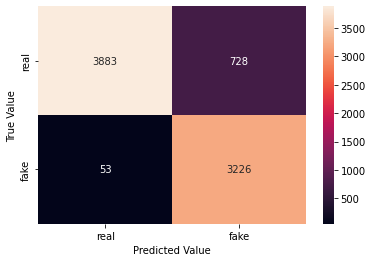

In [ ]:
# Author: Tahsin Chowdhury

metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
plot_confusion_matrix(metrics.confusionMatrix().toArray())


### Gridsearch

In [ ]:
# Author: Tahsin Chowdhury

train_df = train_df.withColumn("label", col("categoryIndex"))
train_df = train_df.cache()

rf = RandomForestClassifier(labelCol="label", featuresCol="features_vec")

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [20, 50, 100])\
            .addGrid(rf.maxBins, [16, 32, 64])\
            .addGrid(rf.bootstrap, [True, False])\
            .addGrid(rf.maxDepth, [5, 7, 10, 20])\
            .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          collectSubModels = True) 

cvModel = crossval.fit(train_df)
best = cvModel.bestModel

print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])
print("\n")

predictionAndLabel = best.transform(test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))

print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
print(metrics.confusionMatrix().toArray())

{Param(parent='RandomForestClassifier_b0c640a28230', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_b0c640a28230', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 64, Param(parent='RandomForestClassifier_b0c640a28230', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_b0c640a28230', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20}


precision: 0.9456246838644411
recall: 1.0
f1 score: 0.9720525152736254


[[3936.  215.]
 [   0. 3739.]]


precision: 0.9456246838644411
recall: 1.0
f1 score: 0.9720525152736254




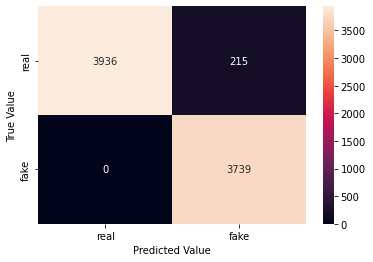

In [ ]:
# Author: Tahsin Chowdhury

# Test scores for best model
predictionAndLabel = best.transform(test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())

{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


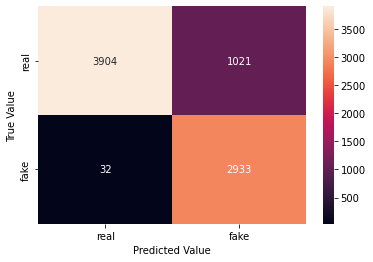



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


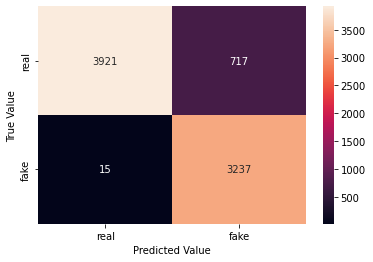



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


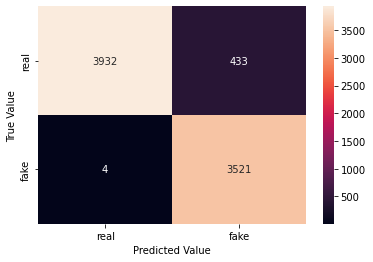



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


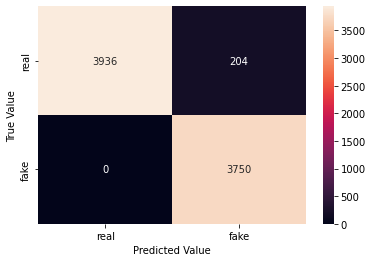



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


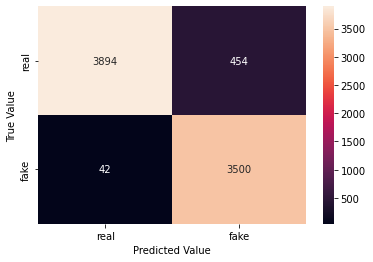



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


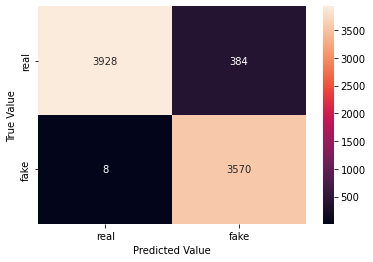



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


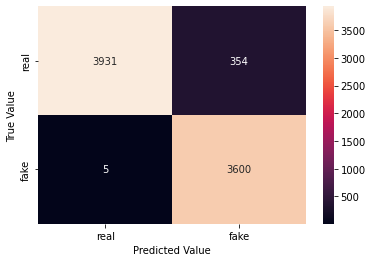



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


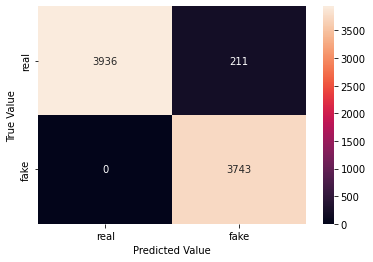



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


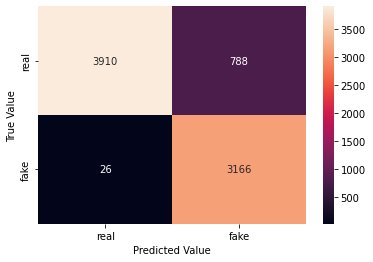



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


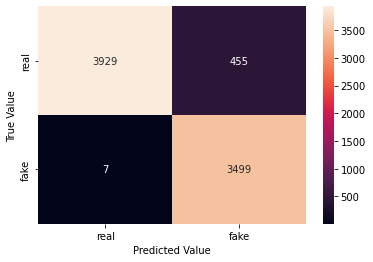



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


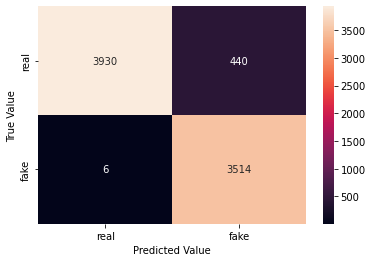



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


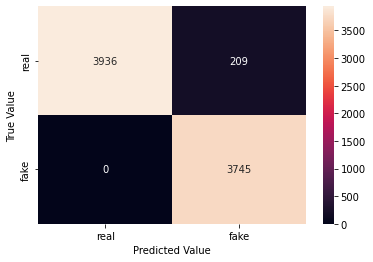



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


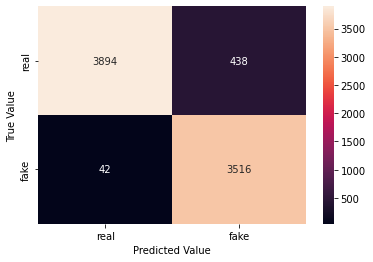



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


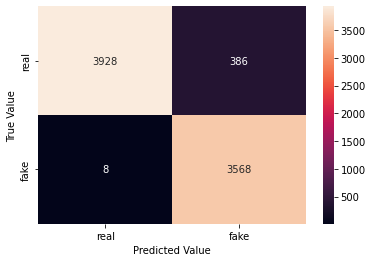



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


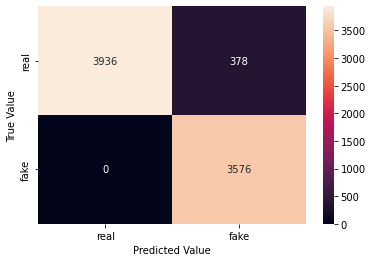



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


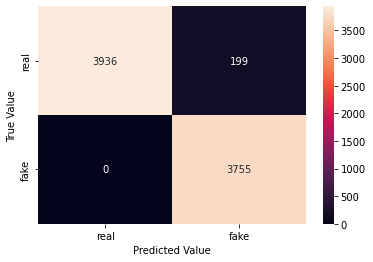



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


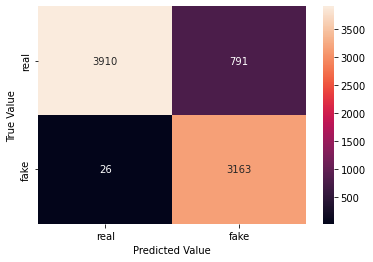



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


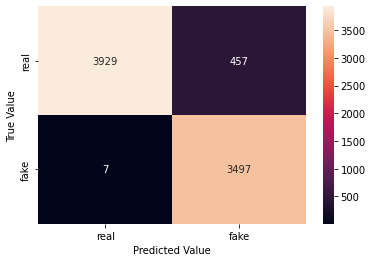



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


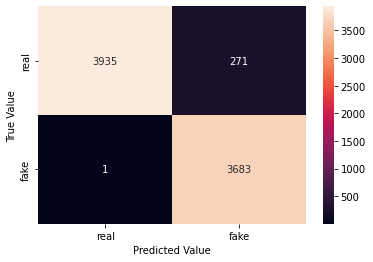



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


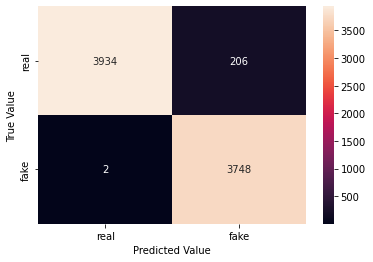



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


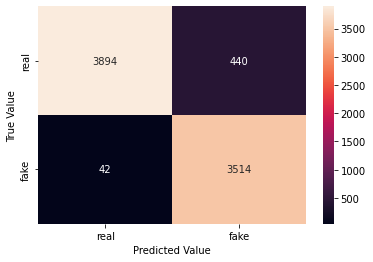



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


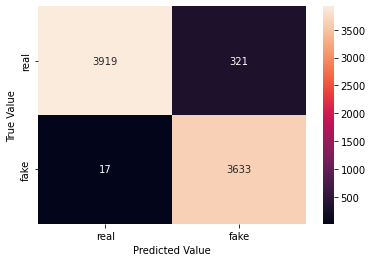



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


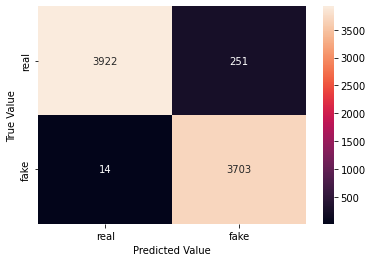



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


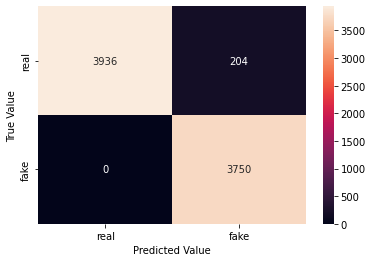



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


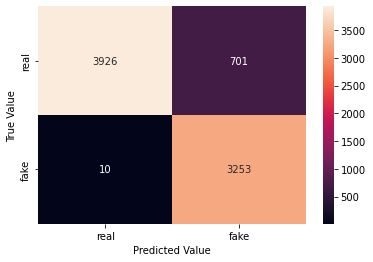



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


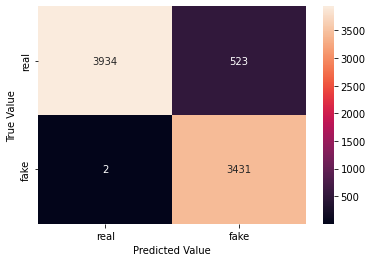



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


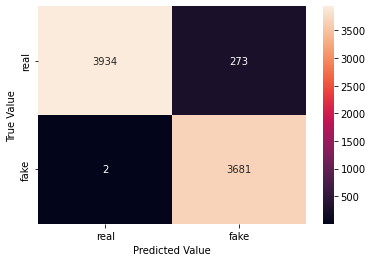



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


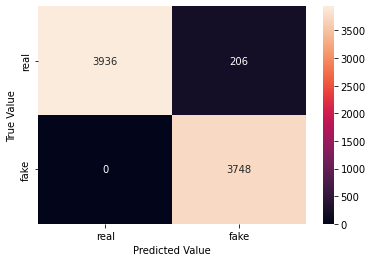



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


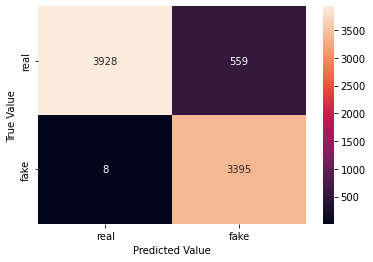



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


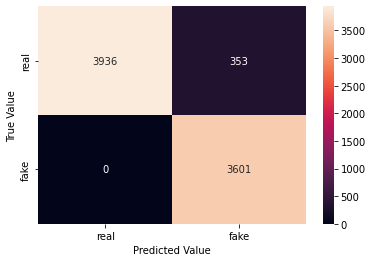



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


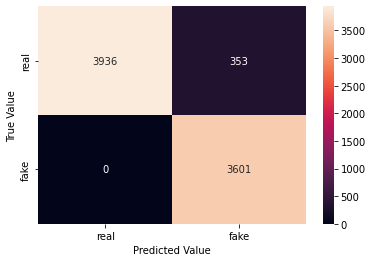



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


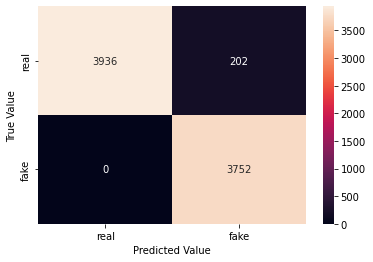



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


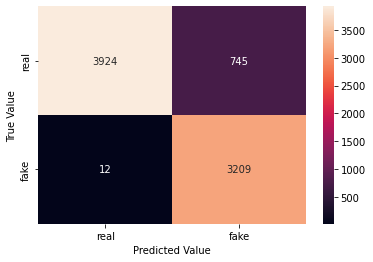



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


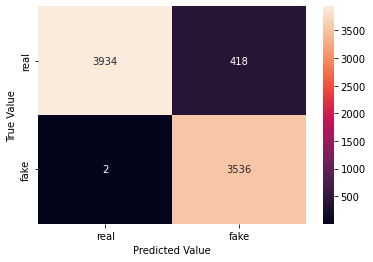



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


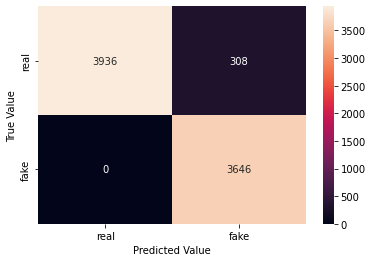



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


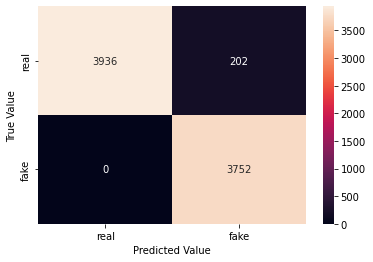



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


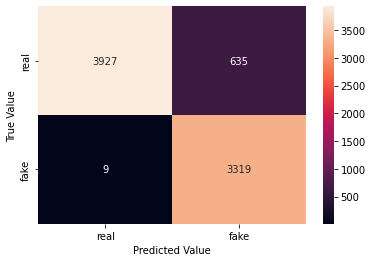



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


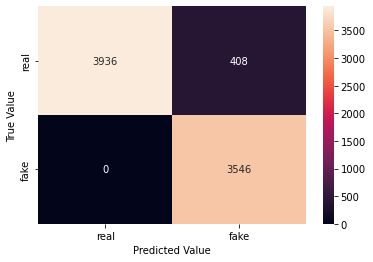



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


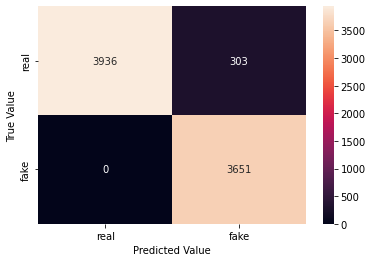



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


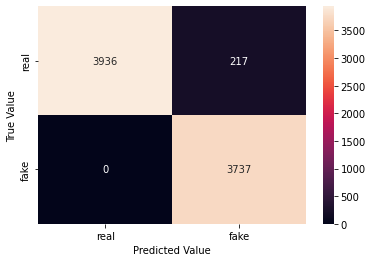



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


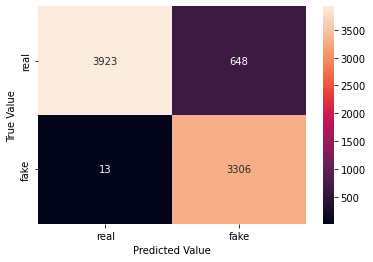



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


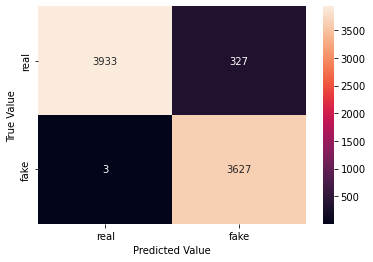



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


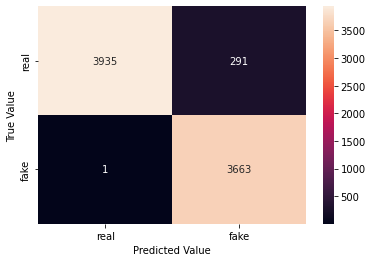



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


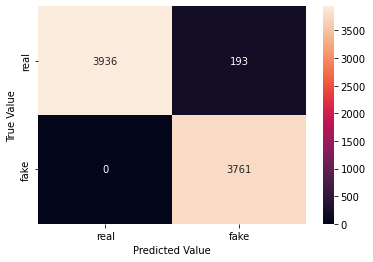



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


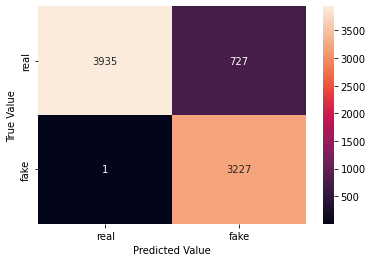



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


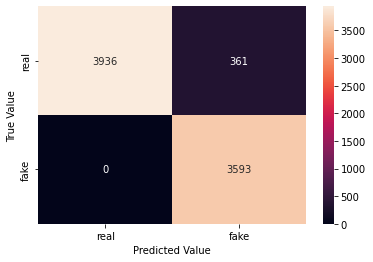



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


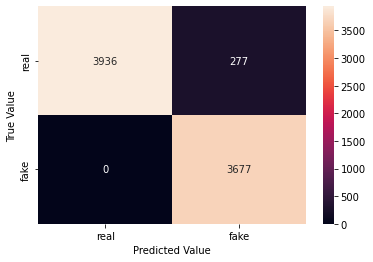



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


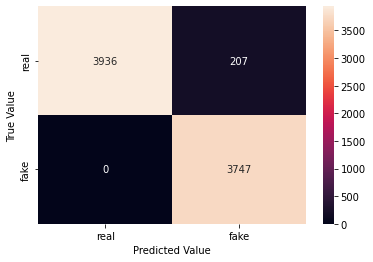



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


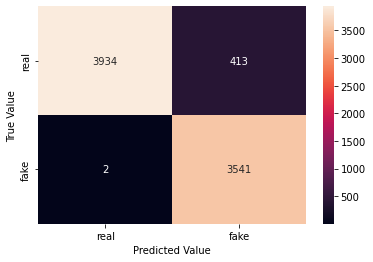



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


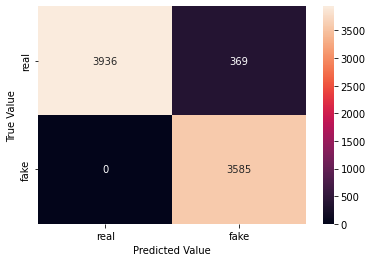



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


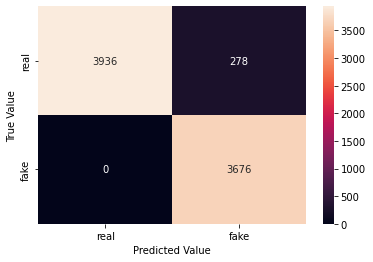



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


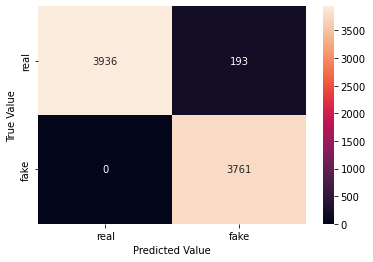



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


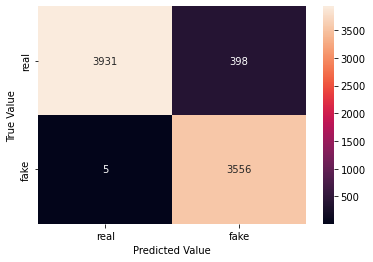



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


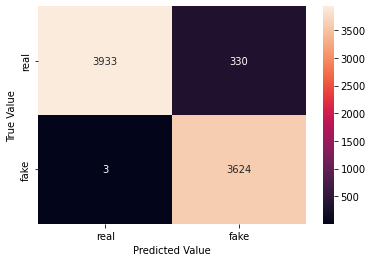



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


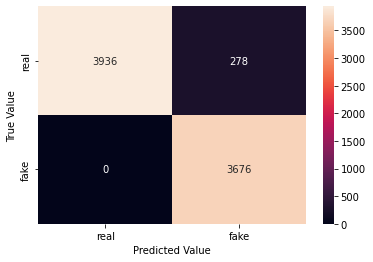



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


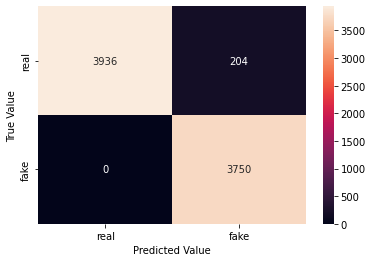



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


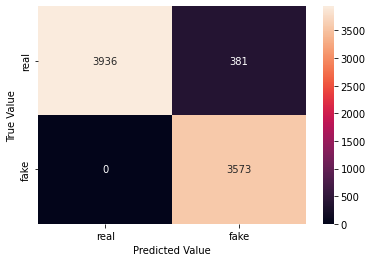



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


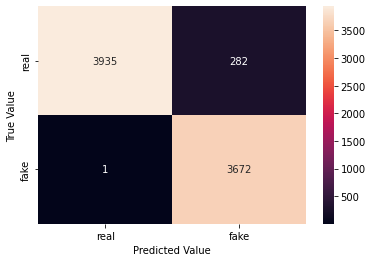



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


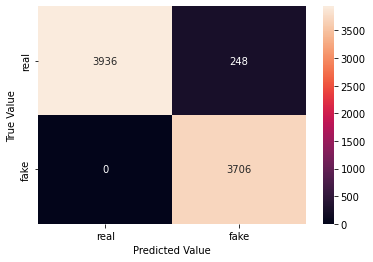



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


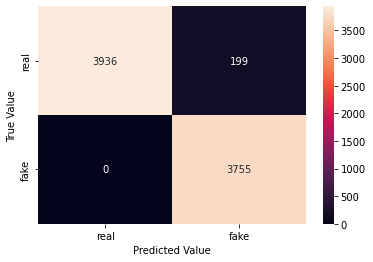



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


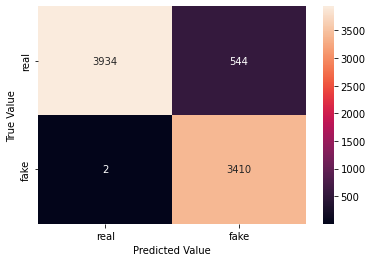



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


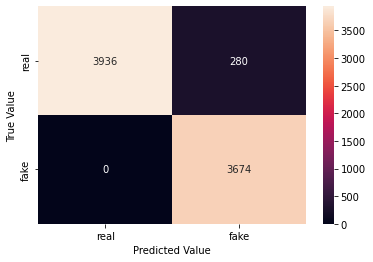



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


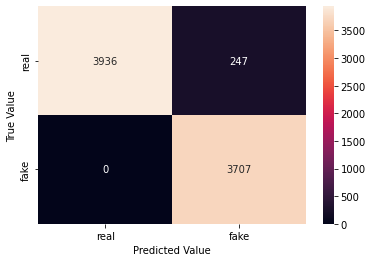



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


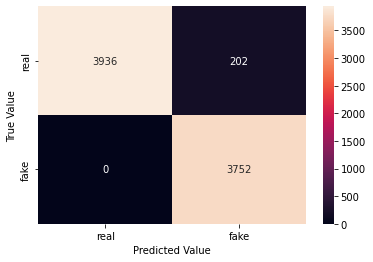



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


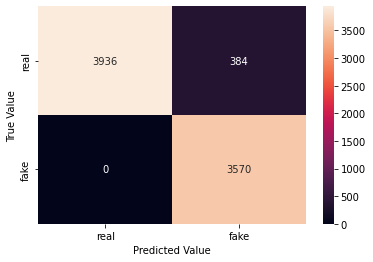



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


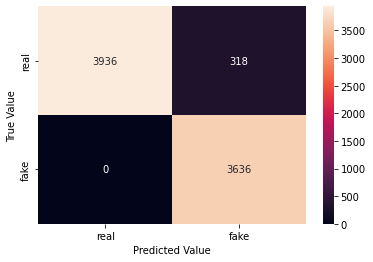



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


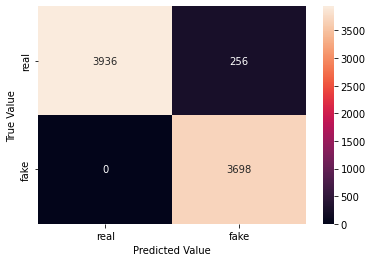



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


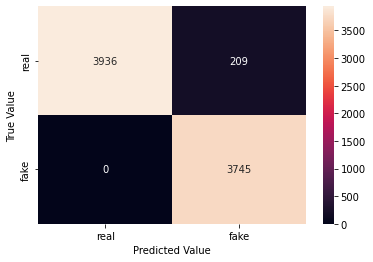



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


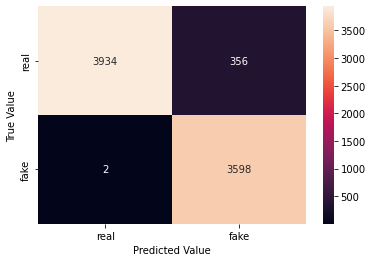



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


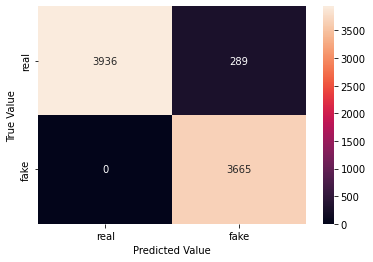



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


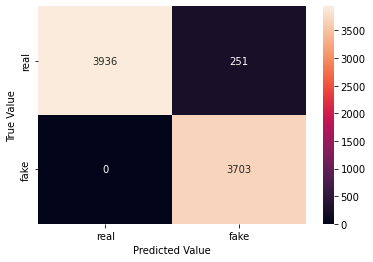



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


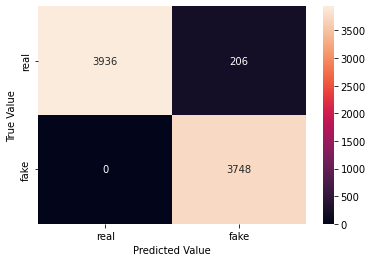



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


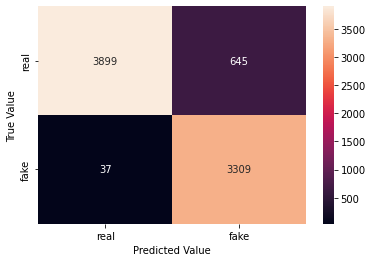



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


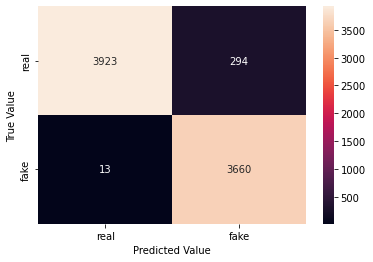



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


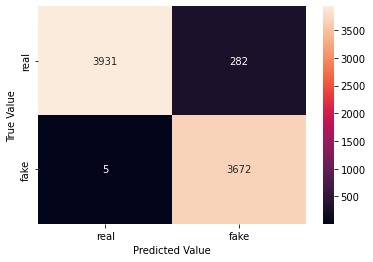



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


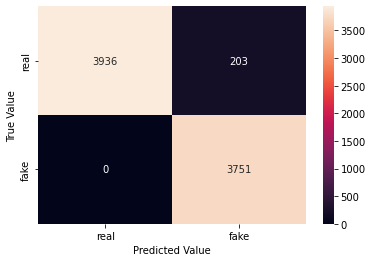



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


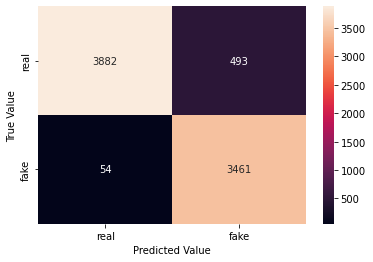



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


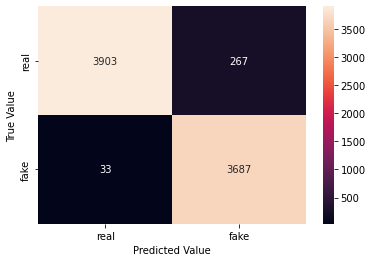



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


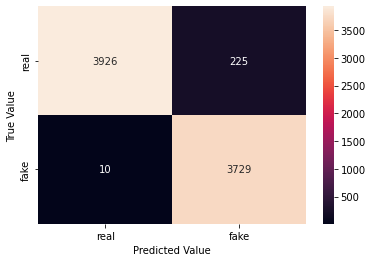



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


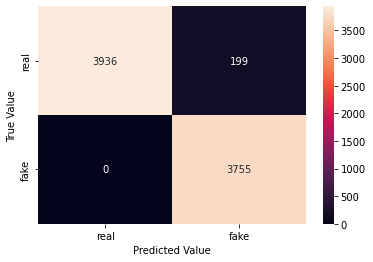



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


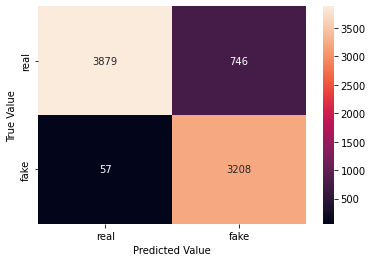



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


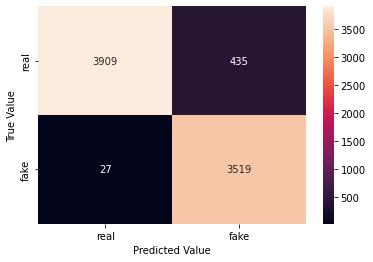



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


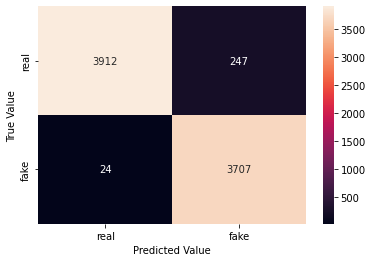



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


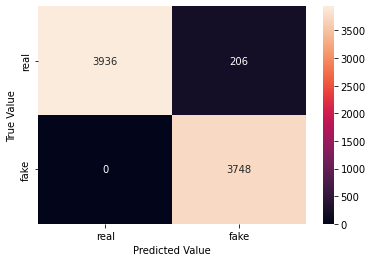



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


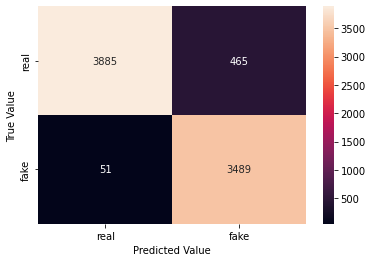



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


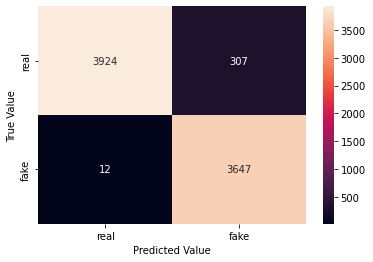



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


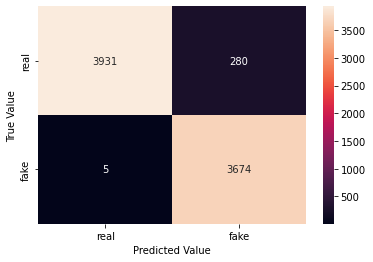



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


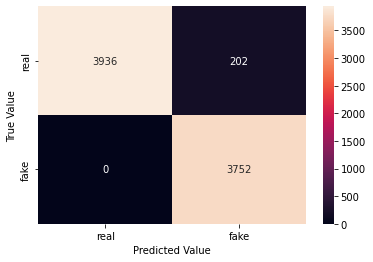



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


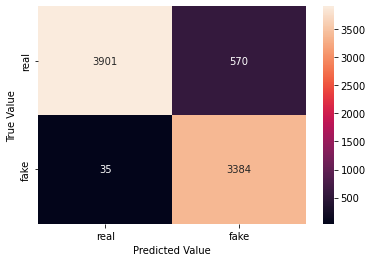



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


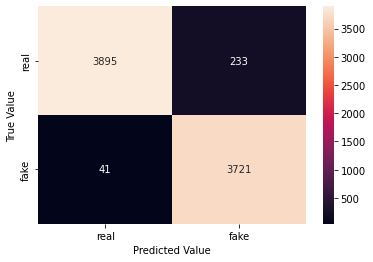



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


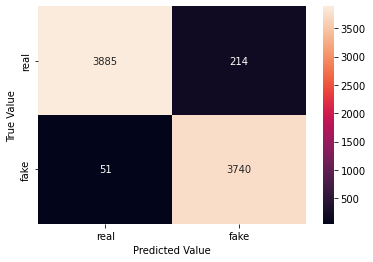



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


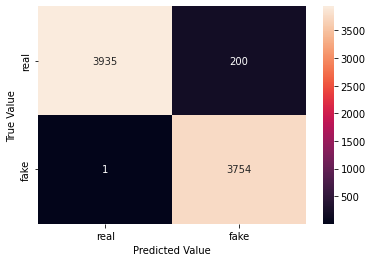



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


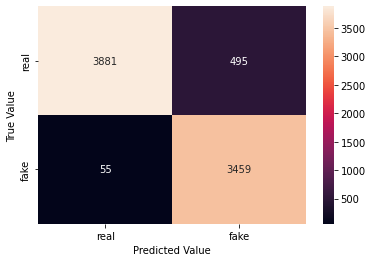



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


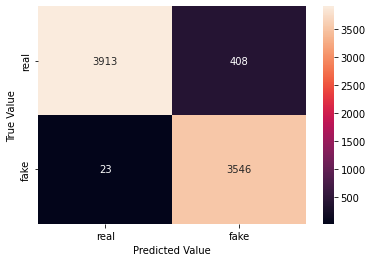



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


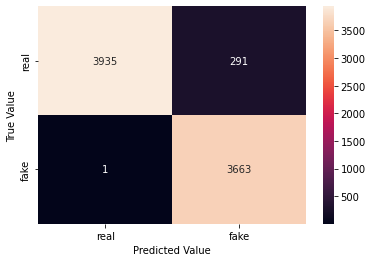



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


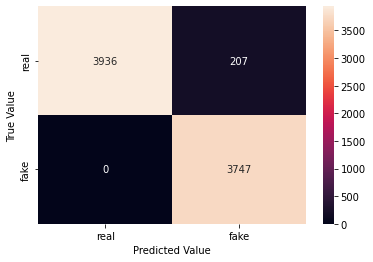



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


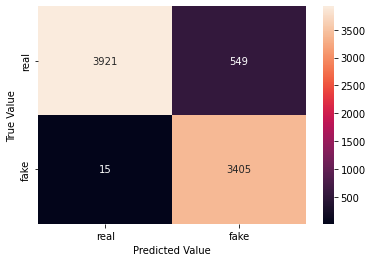



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


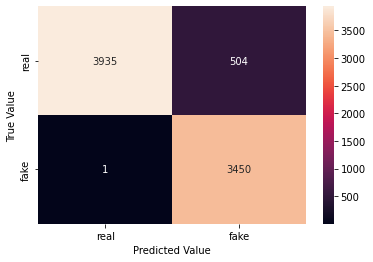



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


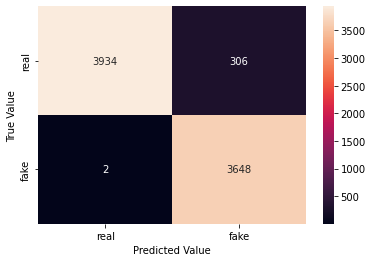



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


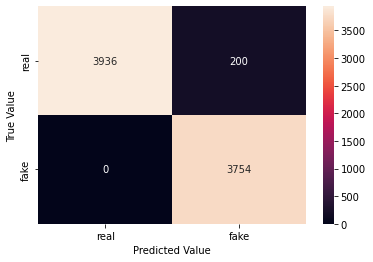



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


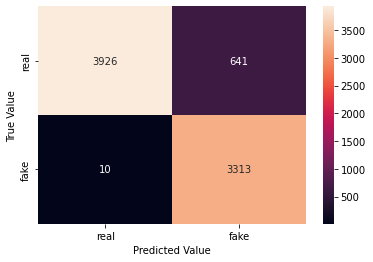



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


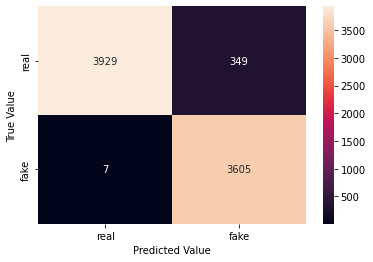



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


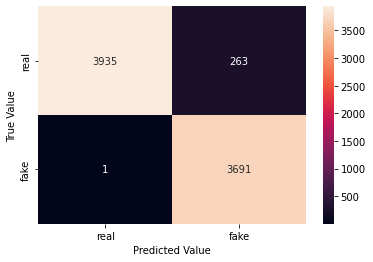



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


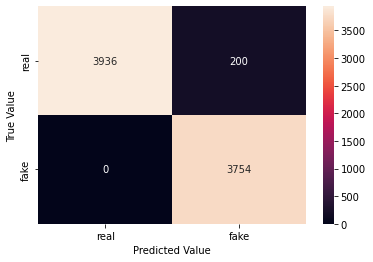



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


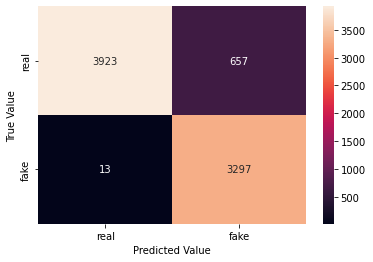



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


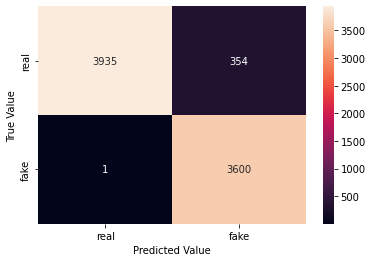



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


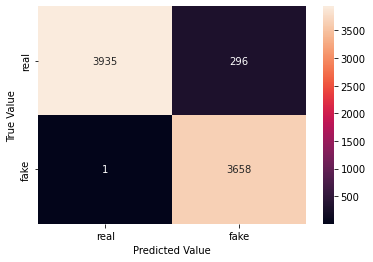



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


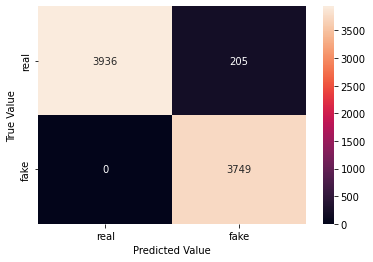



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


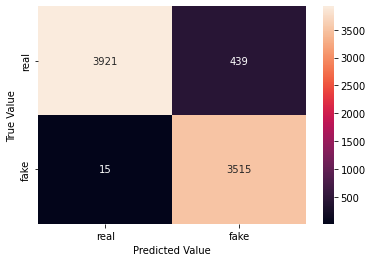



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


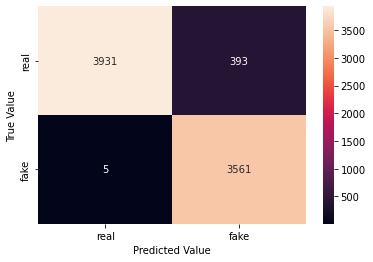



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


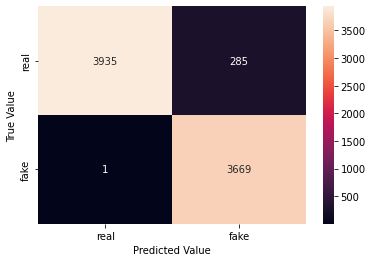



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


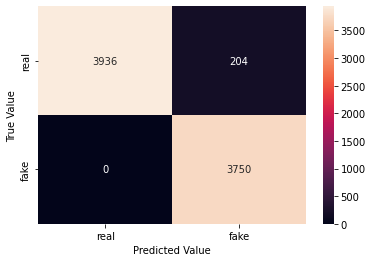



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


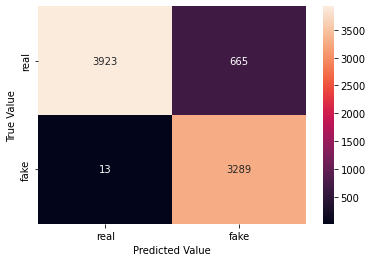



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


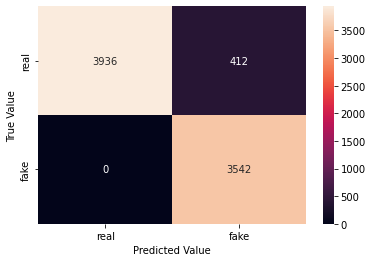



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


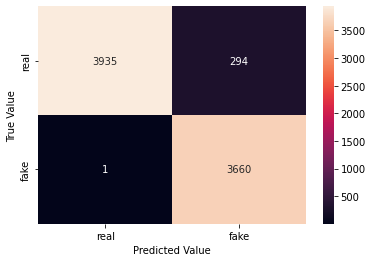



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


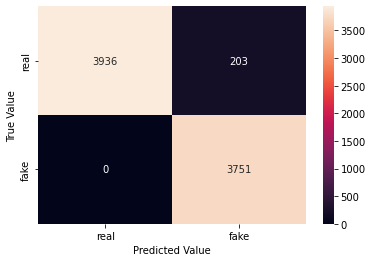



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


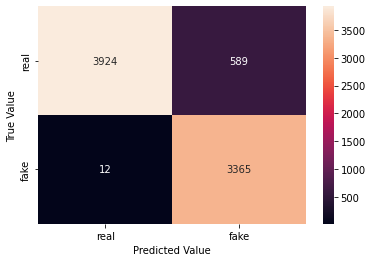



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


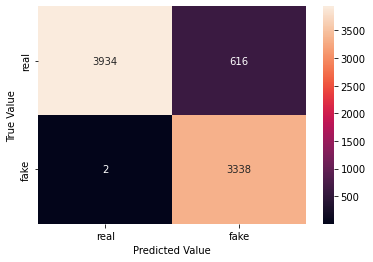



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


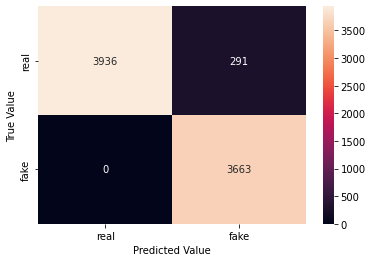



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


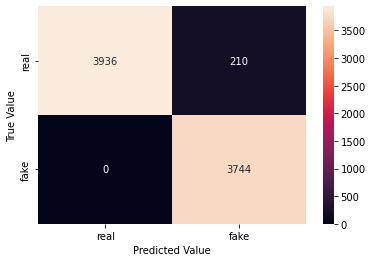



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


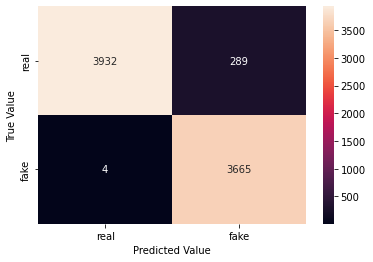



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


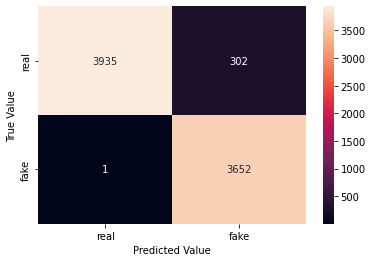



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


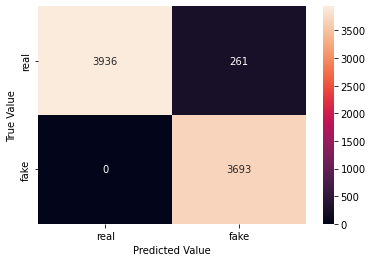



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


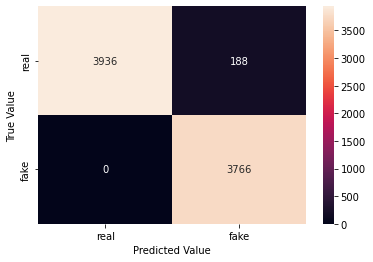



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


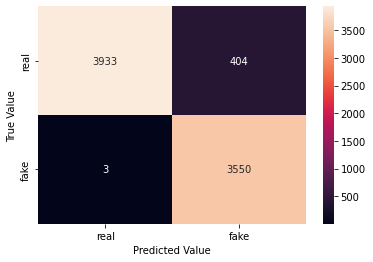



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


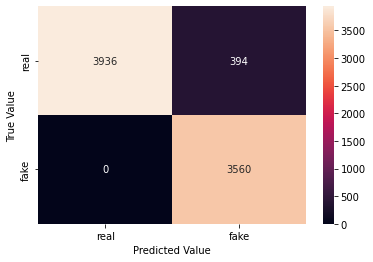



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


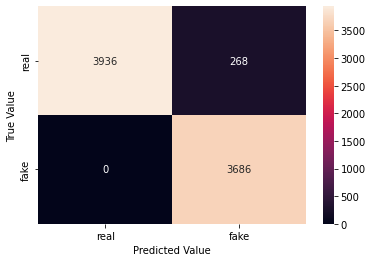



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


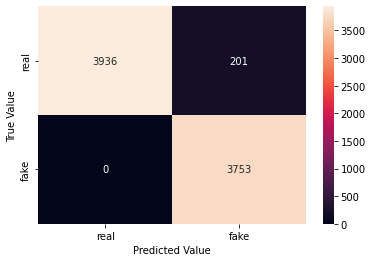



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


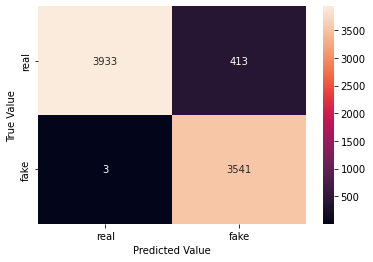



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


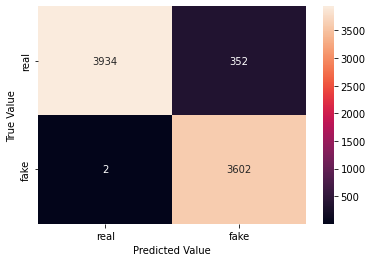



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


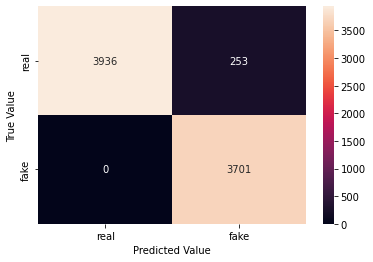



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


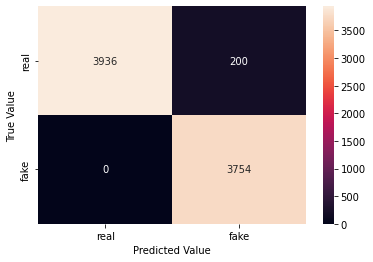



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


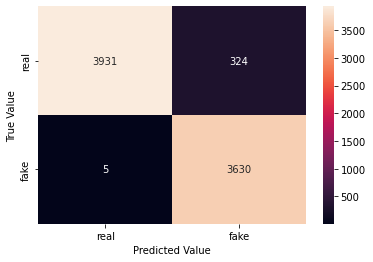



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


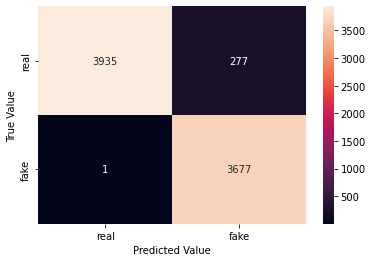



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


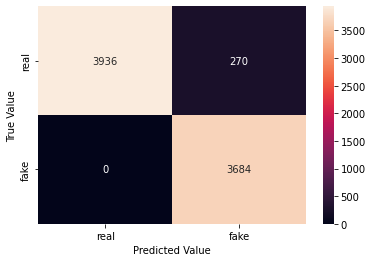



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


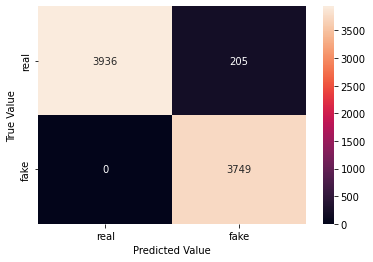



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


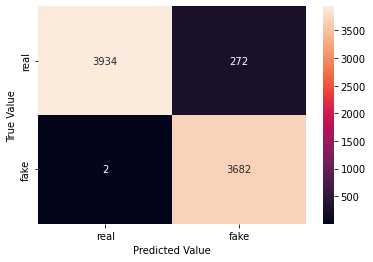



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


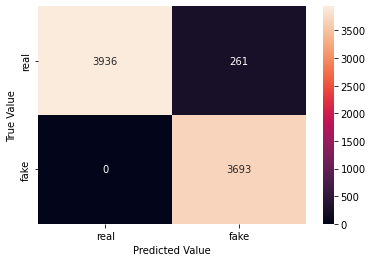



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


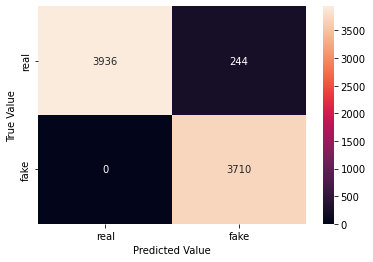



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


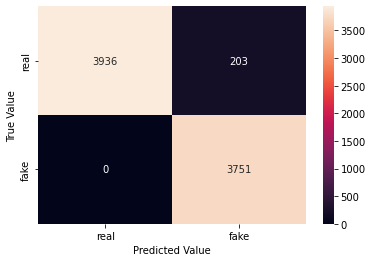



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


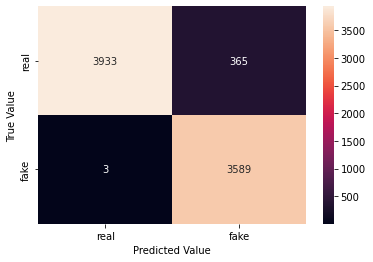



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


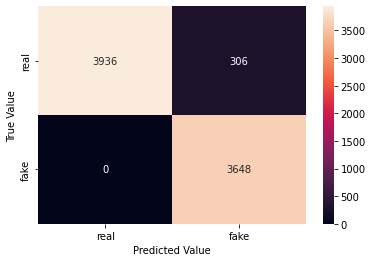



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


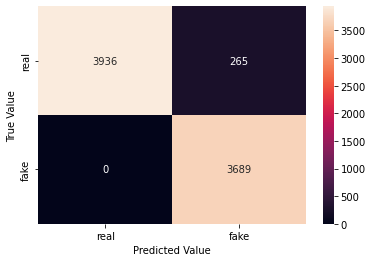



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


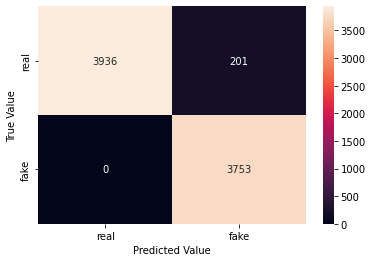



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


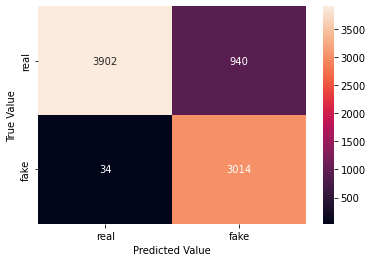



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


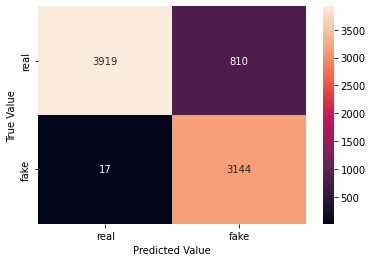



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


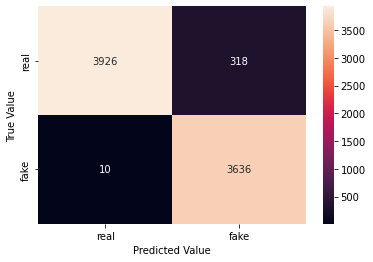



{'numTrees': 20, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


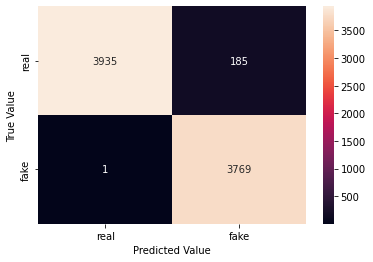



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


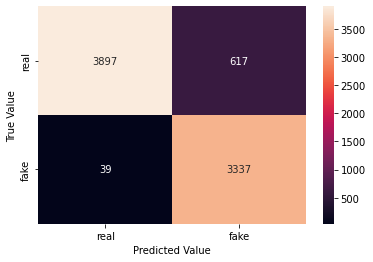



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


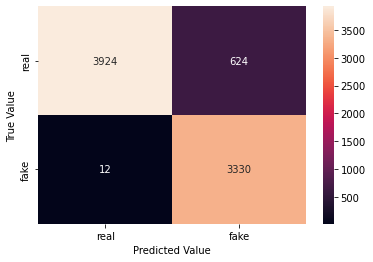



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


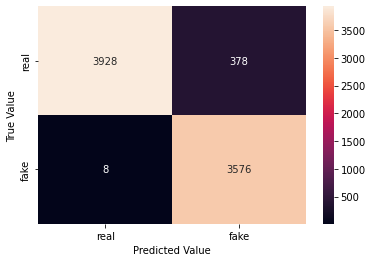



{'numTrees': 20, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


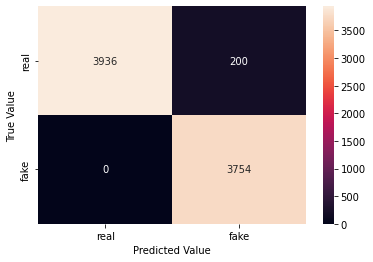



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


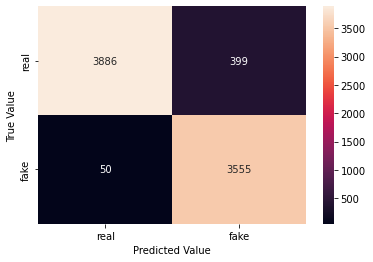



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


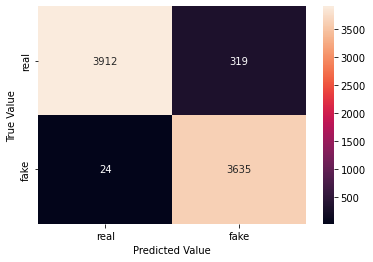



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


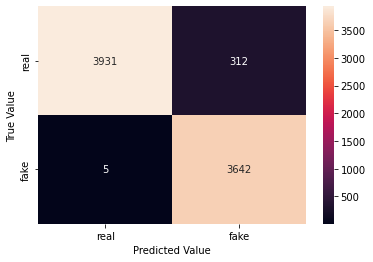



{'numTrees': 20, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


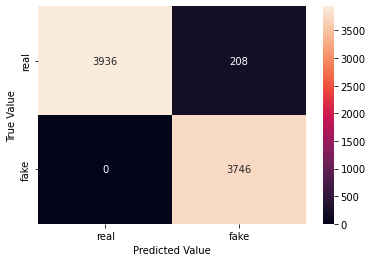



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


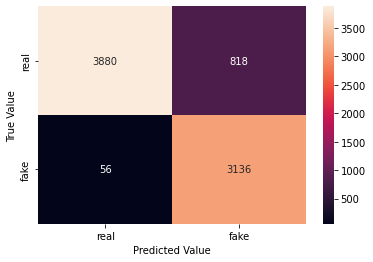



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


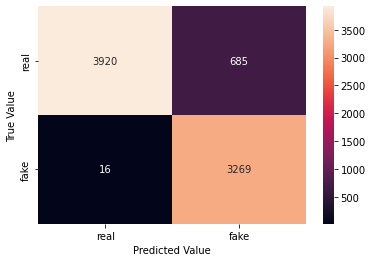



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


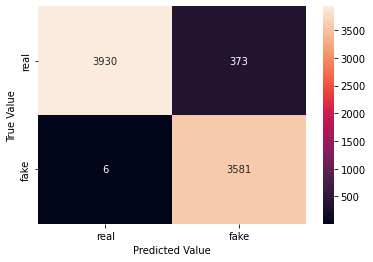



{'numTrees': 20, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


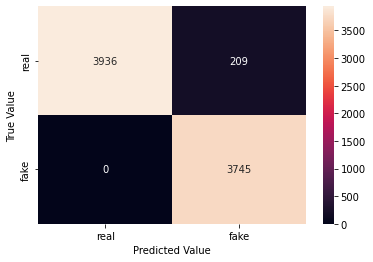



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


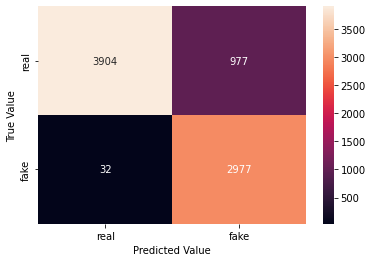



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


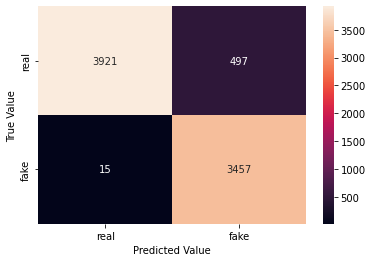



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


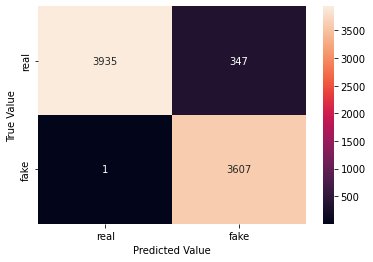



{'numTrees': 20, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


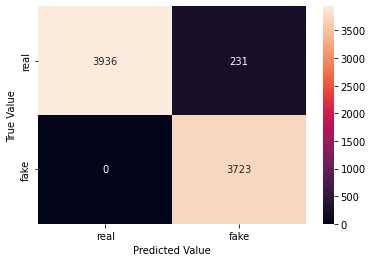



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


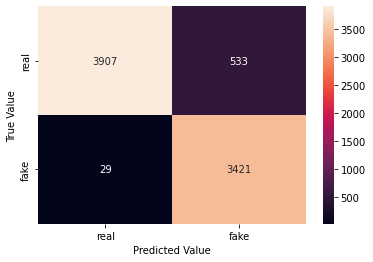



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


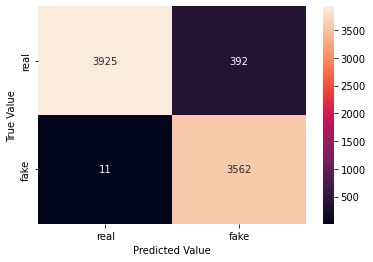



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


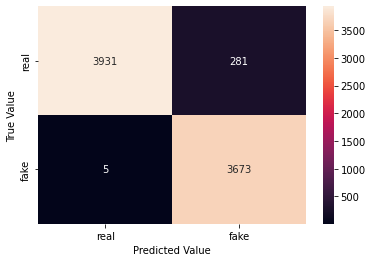



{'numTrees': 20, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


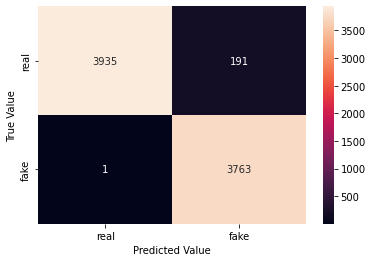



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


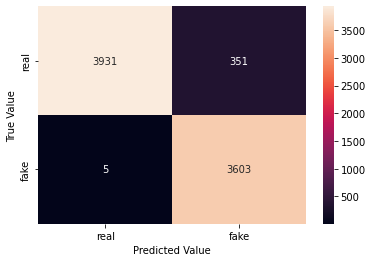



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


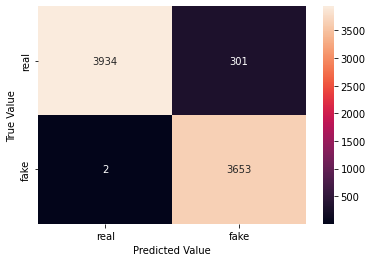



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


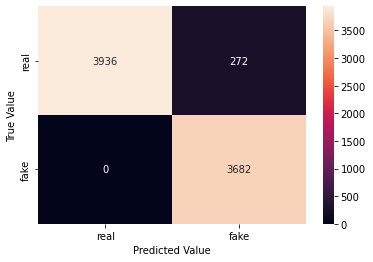



{'numTrees': 50, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


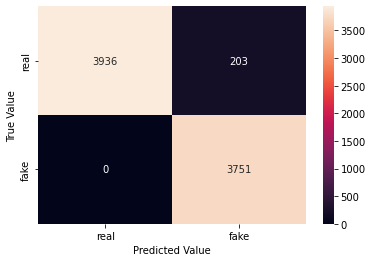



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


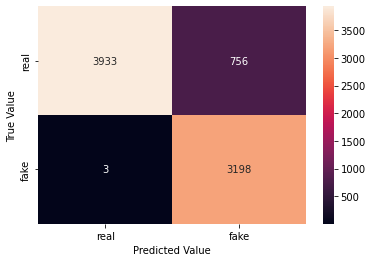



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


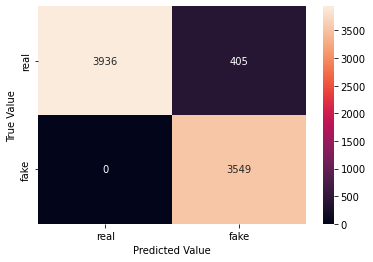



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


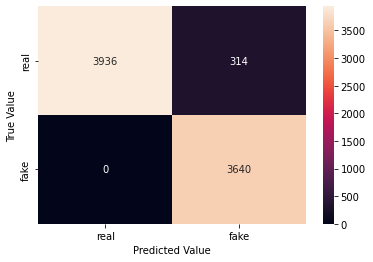



{'numTrees': 50, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


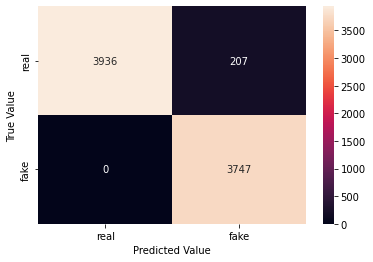



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


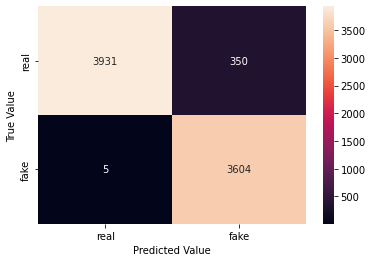



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


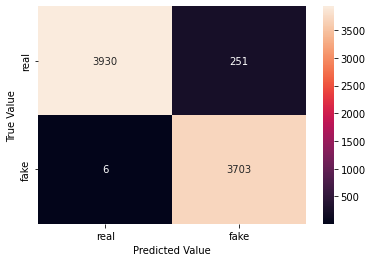



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


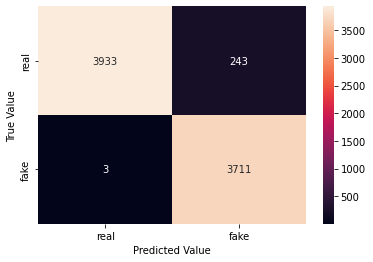



{'numTrees': 50, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


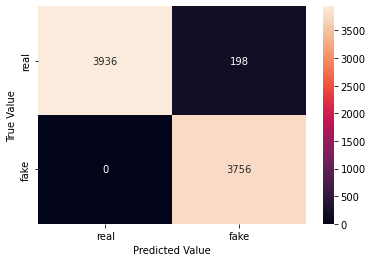



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


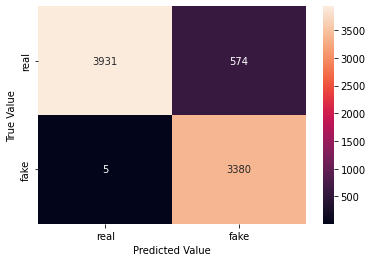



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


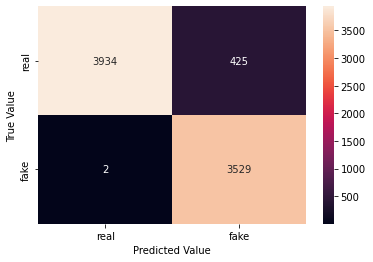



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


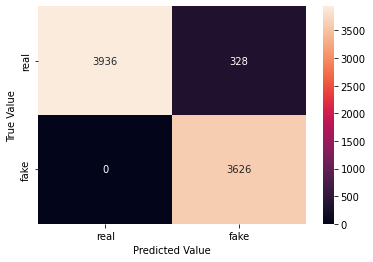



{'numTrees': 50, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


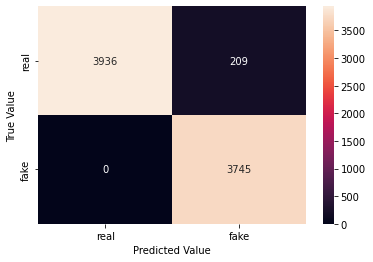



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


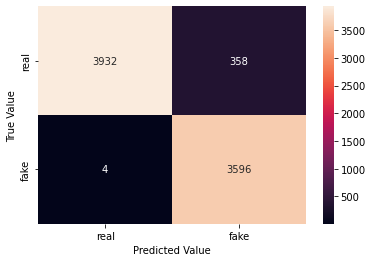



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


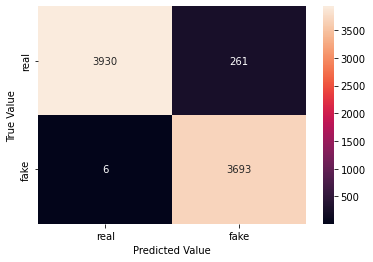



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


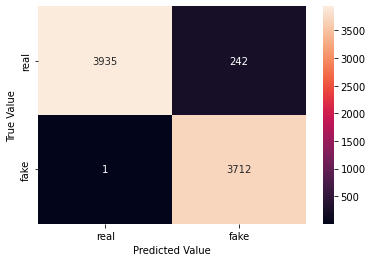



{'numTrees': 50, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


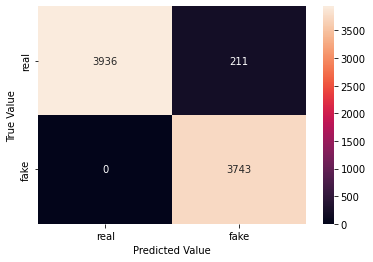



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


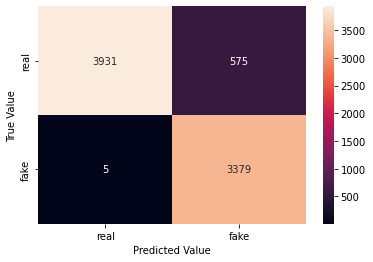



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


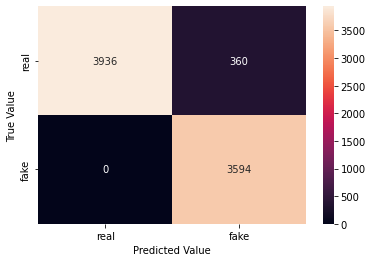



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


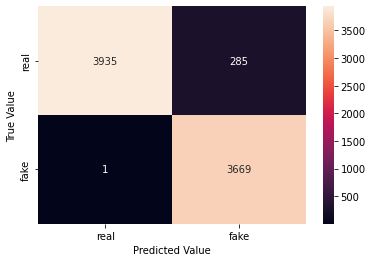



{'numTrees': 50, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


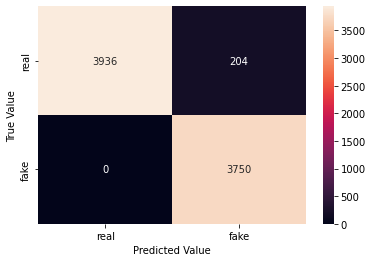



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 5}


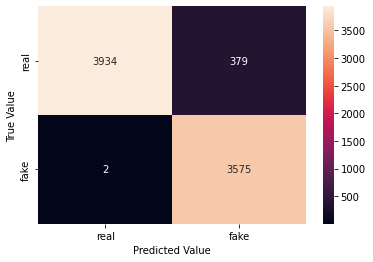



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 7}


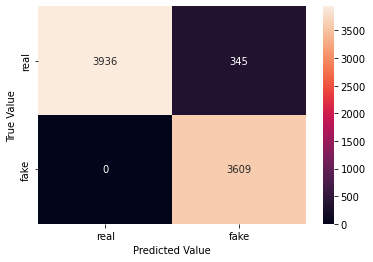



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 10}


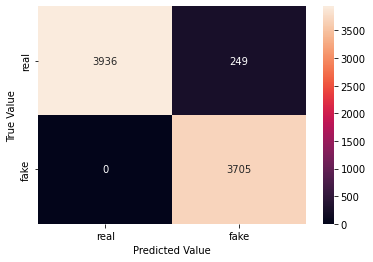



{'numTrees': 100, 'maxBins': 16, 'bootstrap': True, 'maxDepth': 20}


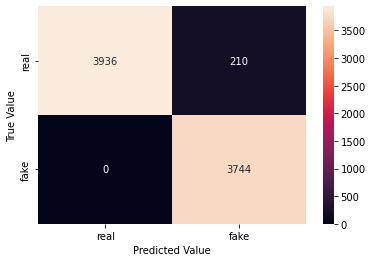



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 5}


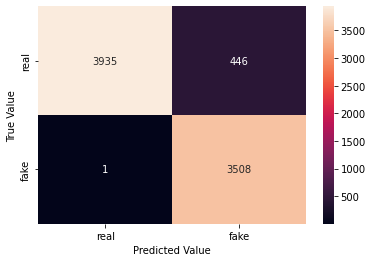



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 7}


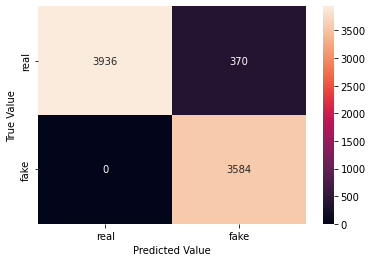



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 10}


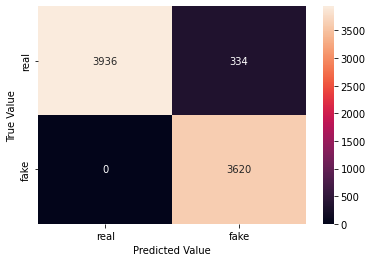



{'numTrees': 100, 'maxBins': 16, 'bootstrap': False, 'maxDepth': 20}


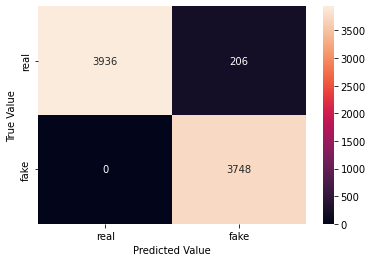



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 5}


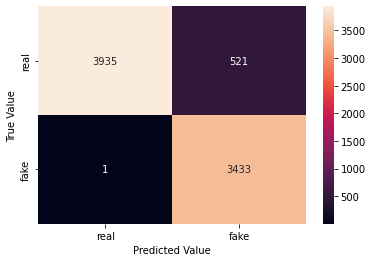



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 7}


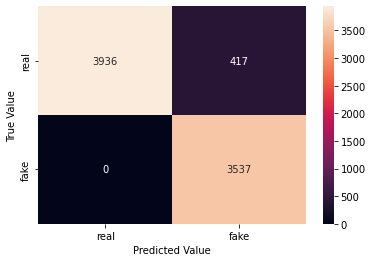



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 10}


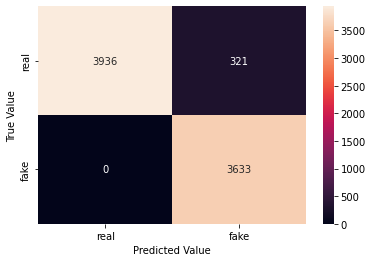



{'numTrees': 100, 'maxBins': 32, 'bootstrap': True, 'maxDepth': 20}


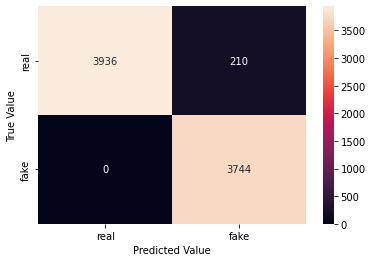



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 5}


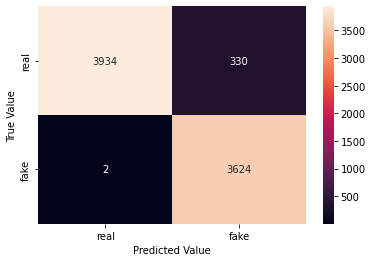



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 7}


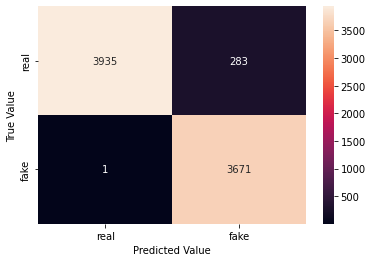



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 10}


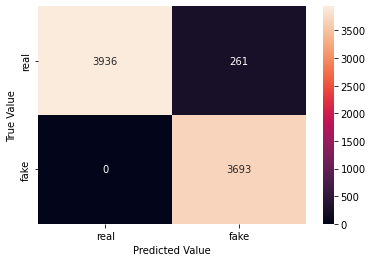



{'numTrees': 100, 'maxBins': 32, 'bootstrap': False, 'maxDepth': 20}


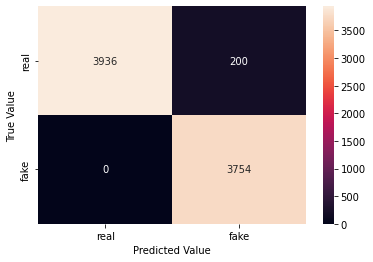



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 5}


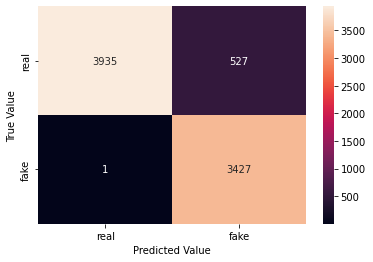



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 7}


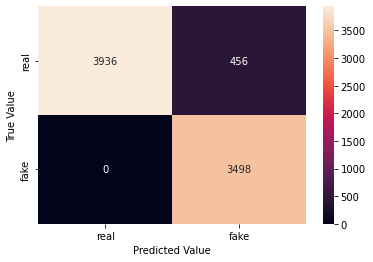



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 10}


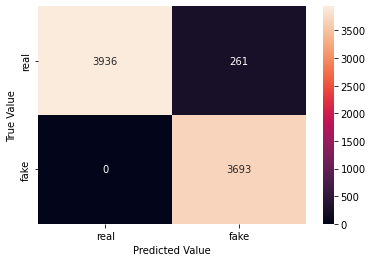



{'numTrees': 100, 'maxBins': 64, 'bootstrap': True, 'maxDepth': 20}


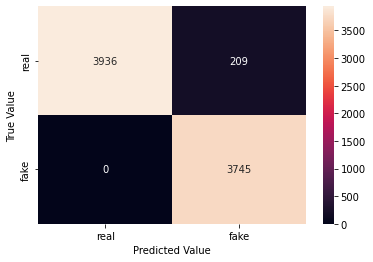



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 5}


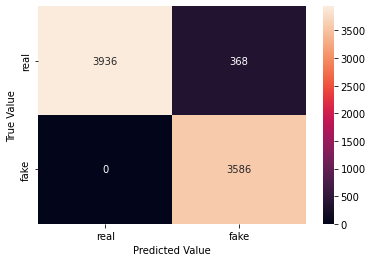



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 7}


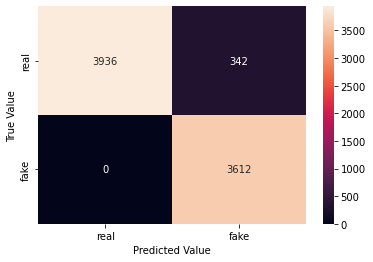



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 10}


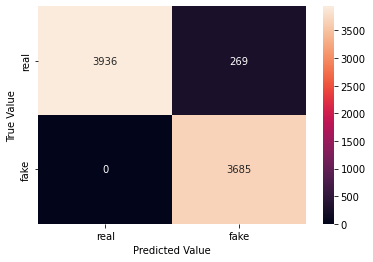



{'numTrees': 100, 'maxBins': 64, 'bootstrap': False, 'maxDepth': 20}


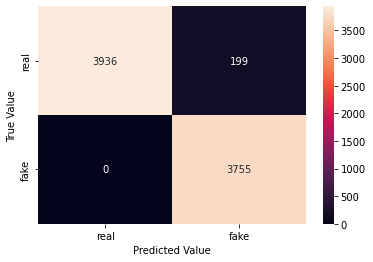

In [ ]:
# Author: Tahsin Chowdhury

# test confusion matrix for every hyperparameter combination
for l in cvModel.subModels:
    for m in l:
        predictionAndLabel = m.transform(test_df).select("categoryIndex", "prediction")
        metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))

        java_model = m._java_obj
        print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) for param in paramGrid[0]})
        plot_confusion_matrix(metrics.confusionMatrix().toArray())
        print("\n")

## Random Forest On Original Dataset Only

***ORGININAL ONLY***

precision: 0.9061822125813449
recall: 0.989635771394729
f1 score: 0.9460721868365181




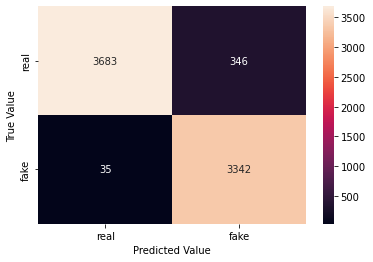

In [ ]:
# Author: Tahsin Chowdhury

rf = RandomForestClassifier(featuresCol= 'features_vec', labelCol='categoryIndex').fit(original_train_df)

print("***ORGININAL ONLY***\n")
predictionAndLabel = rf.transform(original_test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())

## Random Forest On New Dataset Only

***NEW ONLY***

precision: 0.7857142857142857
recall: 0.99
f1 score: 0.8761061946902654




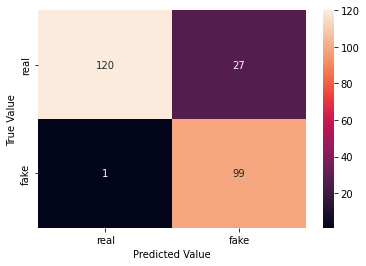

In [ ]:
# Author: Tahsin Chowdhury

rf = RandomForestClassifier(featuresCol= 'features_vec', labelCol='categoryIndex').fit(new_train_df)

print("***NEW ONLY***\n")
predictionAndLabel = rf.transform(new_test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())

## LinearSVC On Original Dataset Only

***ORGININAL ONLY***

precision: 0.9829175704989154
recall: 0.9810554803788903
f1 score: 0.9819856426926723




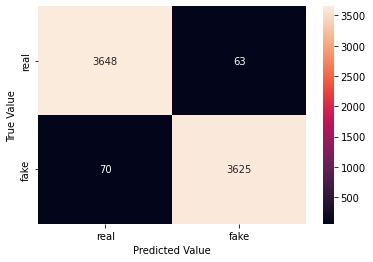

In [ ]:
# Author: Kelten Falez

from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol= 'features_vec', labelCol='categoryIndex').fit(original_train_df)

print("***ORGININAL ONLY***\n")
predictionAndLabel = svm.transform(original_test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())

## LinearSVC On Original + New Dataset

In [ ]:
# Author: Kelten Falez
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol= 'features_vec', labelCol='categoryIndex').fit(train_df)
predictionAndLabel = svm.transform(test_df).select("categoryIndex", "prediction")

precision: 0.9817905918057663
recall: 0.9790668348045397
f1 score: 0.9804268215683799




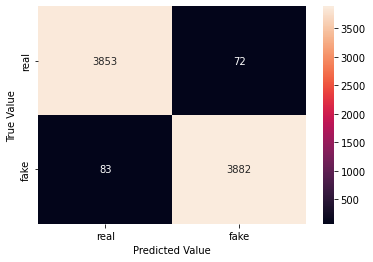

In [ ]:
# Author: Kelten Falez
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())

### Getting Misclassified Tweets

In [ ]:
# Authors: Brandon Attain, Kelten Falez, Tahsin Chowdhury

predictionAndLabel_pd = predictionAndLabel.toPandas()
predictionAndLabel_pd['check'] = predictionAndLabel_pd['categoryIndex'] == predictionAndLabel_pd['prediction']
misclassified_inds = list(predictionAndLabel_pd[predictionAndLabel_pd['check'] == False].index)
test_df_pd = test_df.toPandas()
misclassified_tweets  = test_df_pd[test_df_pd.index.isin(misclassified_inds)]['content']
misclassified_tweets.to_csv('misclassified_tweets.csv')
predictionAndLabel_pd[predictionAndLabel_pd['check'] == False].head(4)

,categoryIndex,prediction,check
115,1.0,0.0,False
140,0.0,1.0,False
171,1.0,0.0,False
277,1.0,0.0,False


### Gridsearch

In [ ]:
# Author: Kelten Falez

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

train_df = train_df.withColumn("label", col("categoryIndex"))
train_df = train_df.cache()

svm = LinearSVC(labelCol="label", featuresCol="features_vec")
#pipeline = Pipeline(stages=[rf])
paramGrid = ParamGridBuilder()\
            .addGrid(svm.regParam, [0.0001, 0.001, 0.01, 0.1])\
            .addGrid(svm.maxIter, [10, 100, 1000])\
            .build()

crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          collectSubModels = True) 

cvModel = crossval.fit(train_df)
best = cvModel.bestModel

print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])
print("\n")

predictionAndLabel = best.transform(test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))

print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
print(metrics.confusionMatrix().toArray())

{Param(parent='LinearSVC_a5832faf6de1', name='regParam', doc='regularization parameter (>= 0).'): 0.0001, Param(parent='LinearSVC_a5832faf6de1', name='maxIter', doc='max number of iterations (>= 0).'): 1000}


precision: 0.9822964087000505
recall: 0.9815516805660854
f1 score: 0.98192390342561


[[3863.   70.]
 [  73. 3884.]]


{'regParam': 0.0001, 'maxIter': 10}


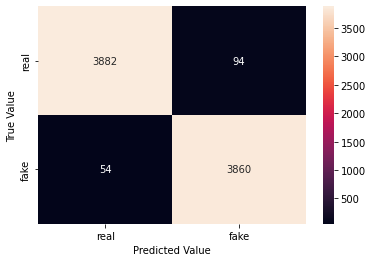



{'regParam': 0.0001, 'maxIter': 100}


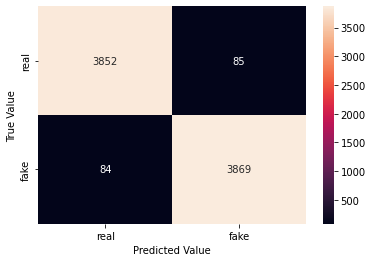



{'regParam': 0.0001, 'maxIter': 1000}


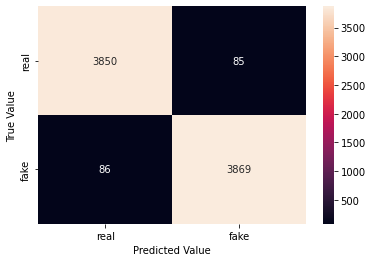



{'regParam': 0.001, 'maxIter': 10}


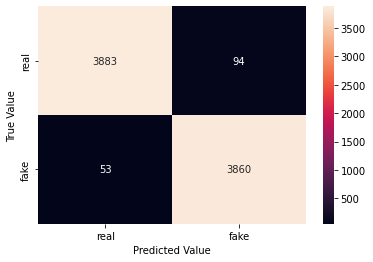



{'regParam': 0.001, 'maxIter': 100}


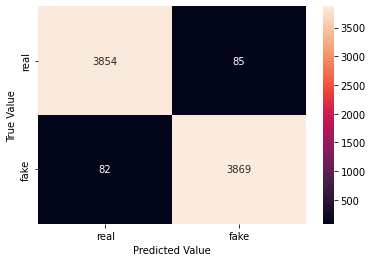



{'regParam': 0.001, 'maxIter': 1000}


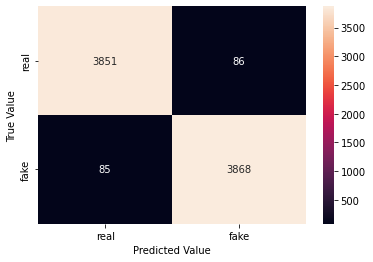



{'regParam': 0.01, 'maxIter': 10}


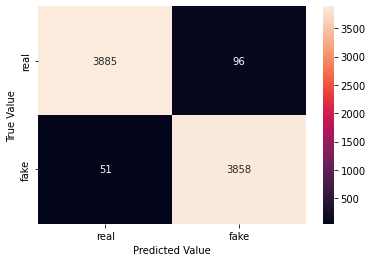



{'regParam': 0.01, 'maxIter': 100}


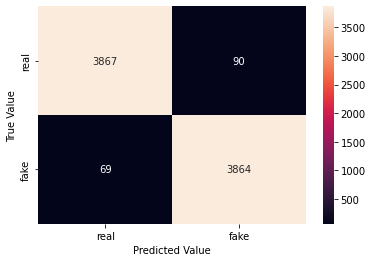



{'regParam': 0.01, 'maxIter': 1000}


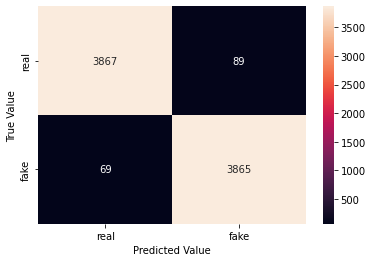



{'regParam': 0.1, 'maxIter': 10}


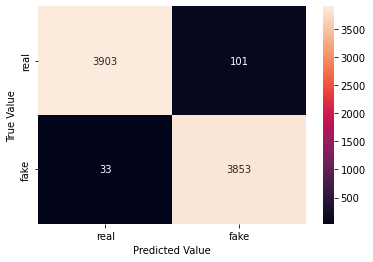



{'regParam': 0.1, 'maxIter': 100}


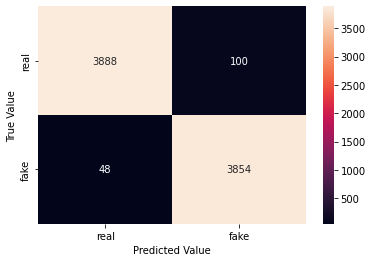



{'regParam': 0.1, 'maxIter': 1000}


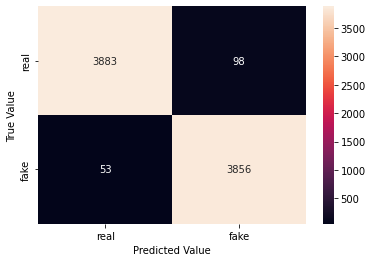



{'regParam': 0.0001, 'maxIter': 10}


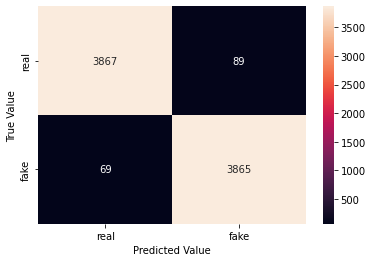



{'regParam': 0.0001, 'maxIter': 100}


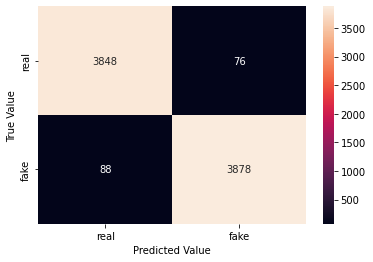



{'regParam': 0.0001, 'maxIter': 1000}


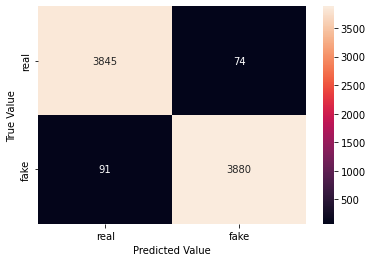



{'regParam': 0.001, 'maxIter': 10}


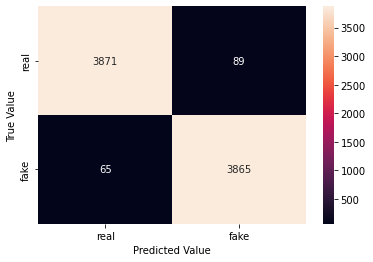



{'regParam': 0.001, 'maxIter': 100}


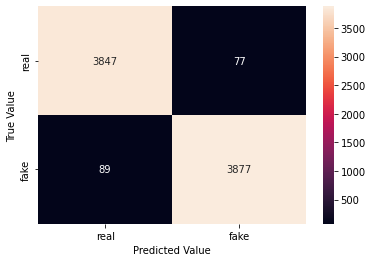



{'regParam': 0.001, 'maxIter': 1000}


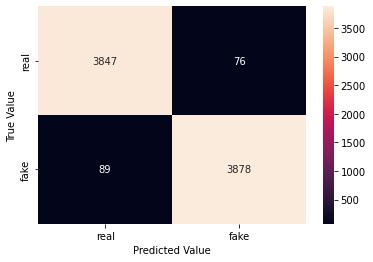



{'regParam': 0.01, 'maxIter': 10}


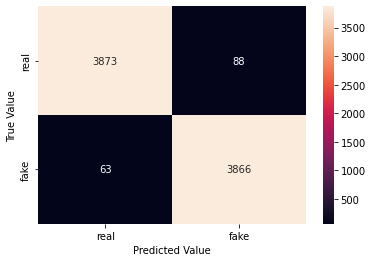



{'regParam': 0.01, 'maxIter': 100}


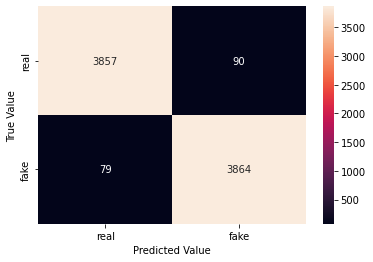



{'regParam': 0.01, 'maxIter': 1000}


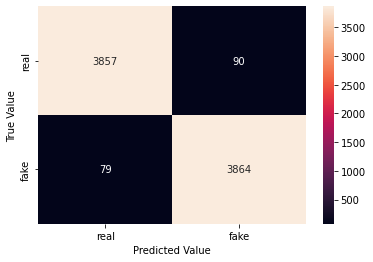



{'regParam': 0.1, 'maxIter': 10}


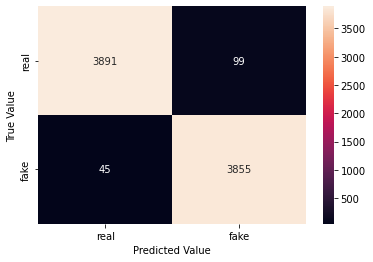



{'regParam': 0.1, 'maxIter': 100}


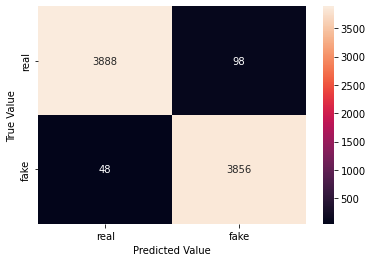



{'regParam': 0.1, 'maxIter': 1000}


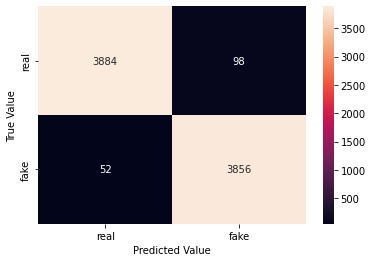



{'regParam': 0.0001, 'maxIter': 10}


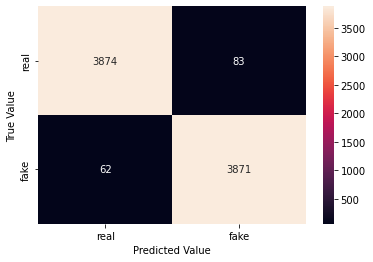



{'regParam': 0.0001, 'maxIter': 100}


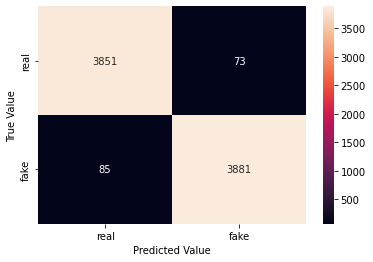



{'regParam': 0.0001, 'maxIter': 1000}


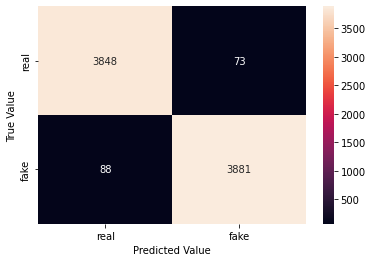



{'regParam': 0.001, 'maxIter': 10}


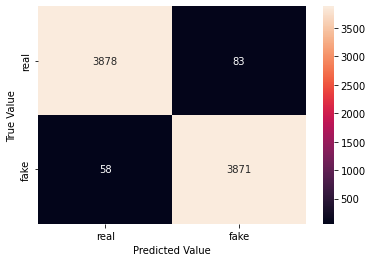



{'regParam': 0.001, 'maxIter': 100}


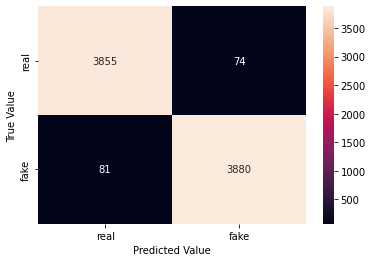



{'regParam': 0.001, 'maxIter': 1000}


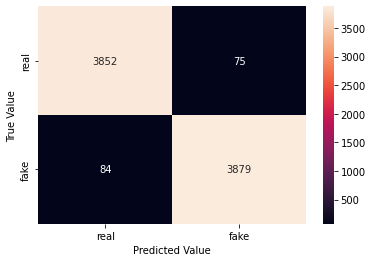



{'regParam': 0.01, 'maxIter': 10}


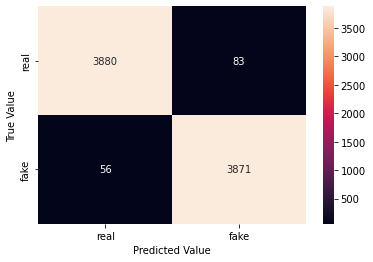



{'regParam': 0.01, 'maxIter': 100}


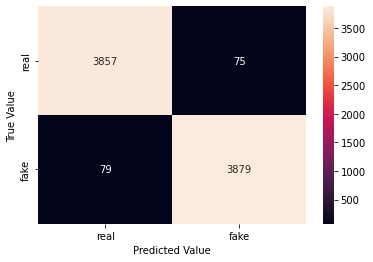



{'regParam': 0.01, 'maxIter': 1000}


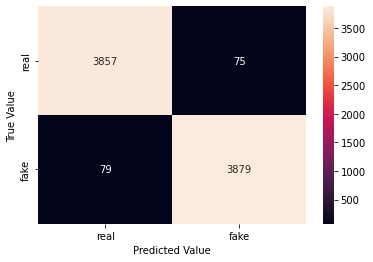



{'regParam': 0.1, 'maxIter': 10}


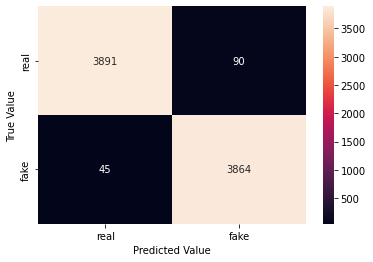



{'regParam': 0.1, 'maxIter': 100}


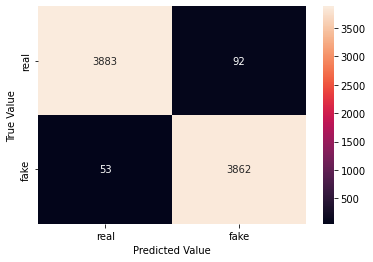



{'regParam': 0.1, 'maxIter': 1000}


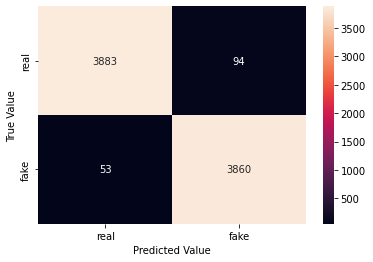

In [ ]:
# Author: Kelten Falez
# test confusion matrix for every hyperparameter combination
for l in cvModel.subModels:
    for m in l:
        predictionAndLabel = m.transform(test_df).select("categoryIndex", "prediction")
        metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))

        java_model = m._java_obj
        print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) for param in paramGrid[0]})
        plot_confusion_matrix(metrics.confusionMatrix().toArray())
        print("\n")

In [ ]:
#Re-evaluate on full dataset
svm_v2 = LinearSVC(featuresCol= 'features_vec', labelCol='categoryIndex', regParam= 0.001,  maxIter = 10 ).fit(train_df)
predictionAndLabel = svm_v2.transform(test_df).select("categoryIndex", "prediction")

In [ ]:
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))

precision: 0.9777440566514921
recall: 0.9854703033392812
f1 score: 0.9815919766408531


## LinearSVC On New Dataset

***NEW ONLY***

precision: 0.9523809523809523
recall: 0.967741935483871
f1 score: 0.96




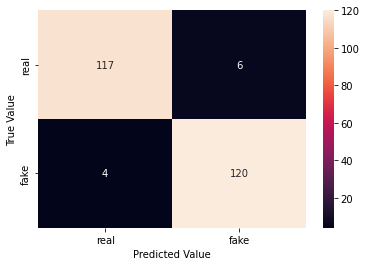

In [ ]:
# Author: Kelten Falez

svm = LinearSVC(featuresCol= 'features_vec', labelCol='categoryIndex').fit(new_train_df)

print("***NEW ONLY***\n")
predictionAndLabel = svm.transform(new_test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())

## Decision Tree Original+New


### Out Of The Box Parameters

In [ ]:
# Author: Brandon Attai
from pyspark.ml.classification import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(featuresCol= 'features_vec', labelCol='categoryIndex').fit(train_df)
predictionAndLabel = dt_classifier.transform(test_df).select("categoryIndex", "prediction")

precision: 0.9613050075872535
recall: 0.9015654648956357
f1 score: 0.9304773561811506


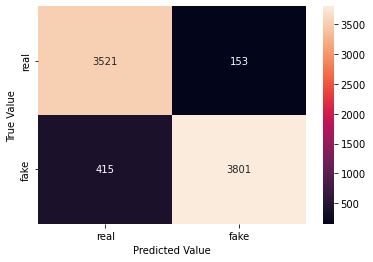

In [ ]:
# Author: Brandon Attai
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
plot_confusion_matrix(metrics.confusionMatrix().toArray())


### Gridsearch

{Param(parent='DecisionTreeClassifier_c7535c54efae', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16, Param(parent='DecisionTreeClassifier_c7535c54efae', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20}


precision: 0.9802731411229135
recall: 0.9610711629060253
f1 score: 0.9705771879303869




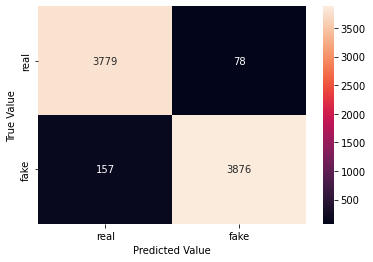

In [ ]:
# Author: Brandon Attai

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features_vec")

paramGrid = ParamGridBuilder()\
            .addGrid(dt.maxBins, [16, 32, 64])\
            .addGrid(dt.maxDepth, [5, 7, 10, 20])\
            .build()


crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          collectSubModels=True) 

cvModel = crossval.fit(train_df)
best = cvModel.bestModel

print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])
print("\n")

predictionAndLabel = best.transform(test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))

print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
# print(metrics.confusionMatrix().toArray())
plot_confusion_matrix(metrics.confusionMatrix().toArray())

precision: 0.9802731411229135
recall: 0.9610711629060253
f1 score: 0.9705771879303869




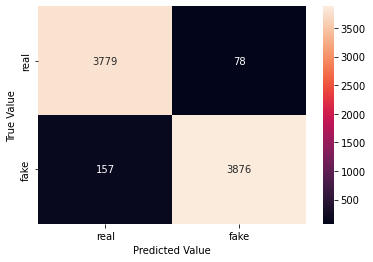

In [ ]:
# Author: Brandon Attai
# Test scores for best model
predictionAndLabel = best.transform(test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())

{'maxBins': 16, 'maxDepth': 5}


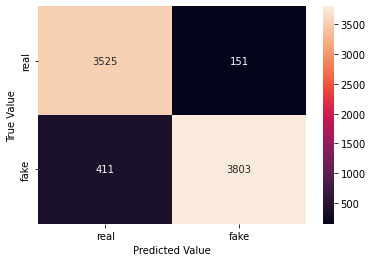



{'maxBins': 16, 'maxDepth': 7}


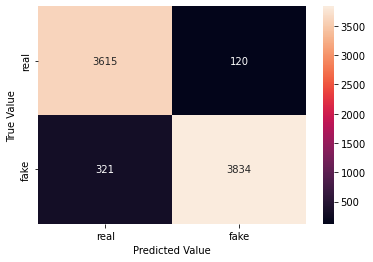



{'maxBins': 16, 'maxDepth': 10}


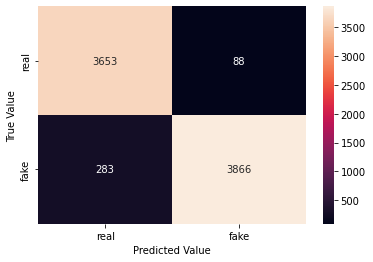



{'maxBins': 16, 'maxDepth': 20}


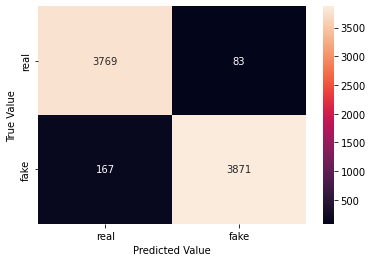



{'maxBins': 32, 'maxDepth': 5}


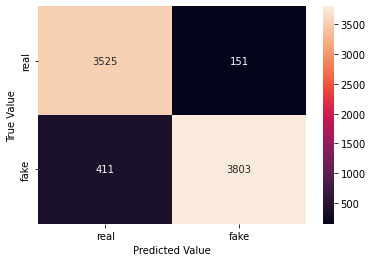



{'maxBins': 32, 'maxDepth': 7}


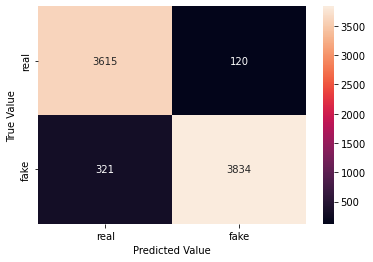



{'maxBins': 32, 'maxDepth': 10}


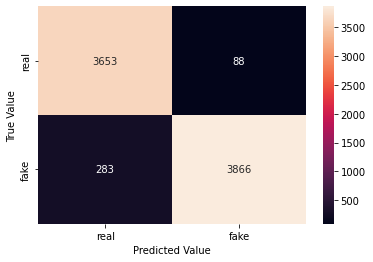



{'maxBins': 32, 'maxDepth': 20}


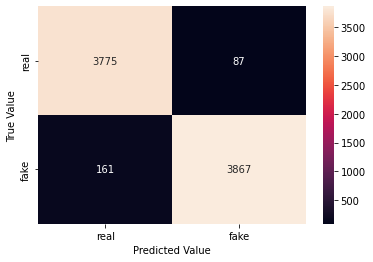



{'maxBins': 64, 'maxDepth': 5}


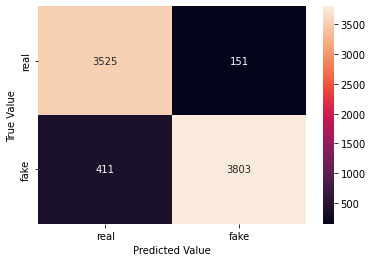



{'maxBins': 64, 'maxDepth': 7}


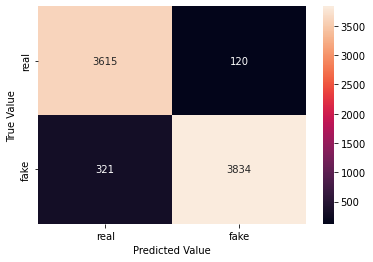



{'maxBins': 64, 'maxDepth': 10}


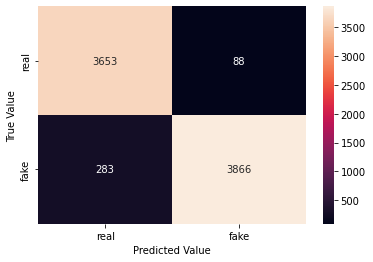



{'maxBins': 64, 'maxDepth': 20}


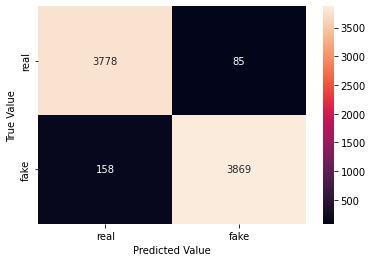



{'maxBins': 16, 'maxDepth': 5}


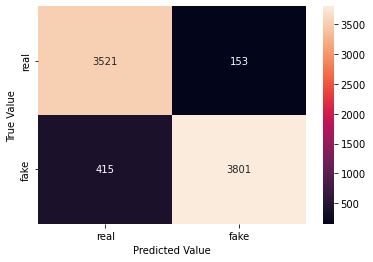



{'maxBins': 16, 'maxDepth': 7}


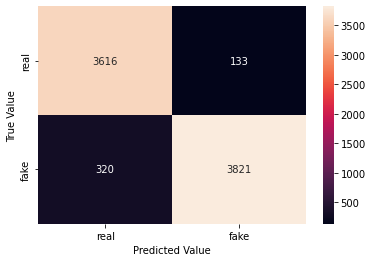



{'maxBins': 16, 'maxDepth': 10}


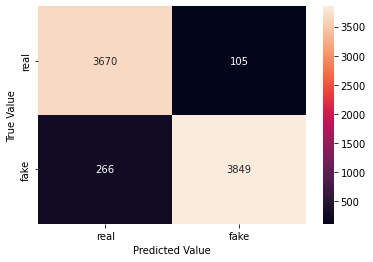



{'maxBins': 16, 'maxDepth': 20}


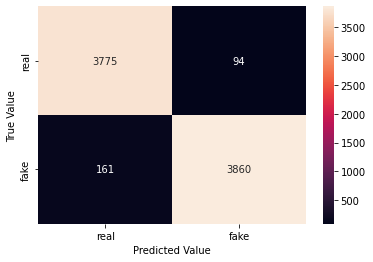



{'maxBins': 32, 'maxDepth': 5}


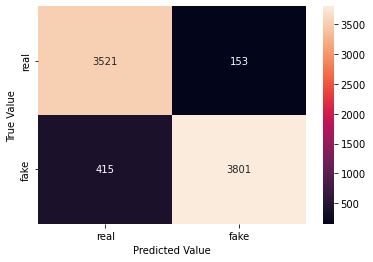



{'maxBins': 32, 'maxDepth': 7}


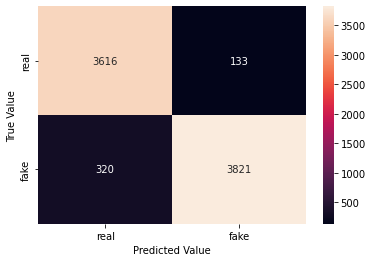



{'maxBins': 32, 'maxDepth': 10}


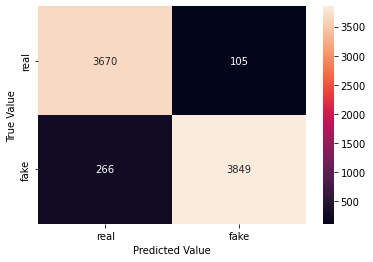



{'maxBins': 32, 'maxDepth': 20}


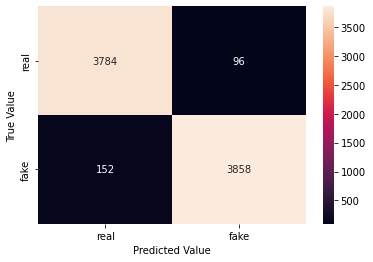



{'maxBins': 64, 'maxDepth': 5}


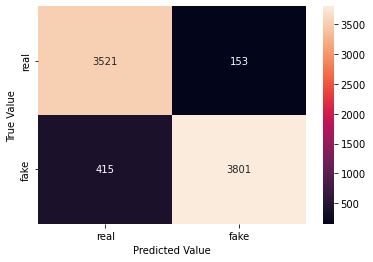



{'maxBins': 64, 'maxDepth': 7}


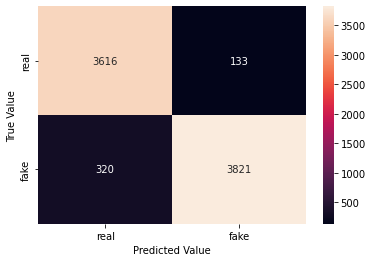



{'maxBins': 64, 'maxDepth': 10}


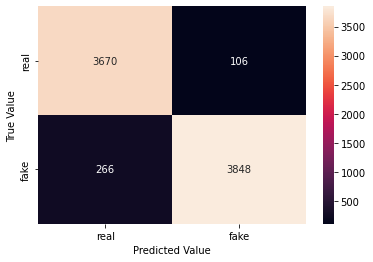



{'maxBins': 64, 'maxDepth': 20}


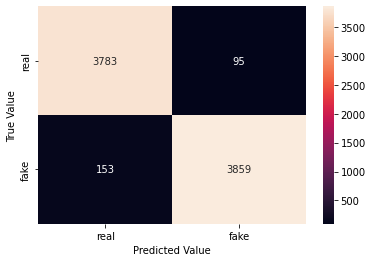



{'maxBins': 16, 'maxDepth': 5}


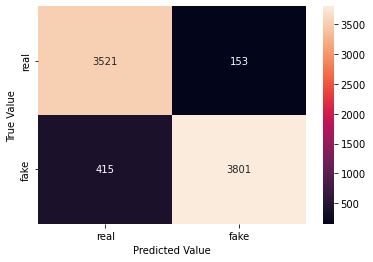



{'maxBins': 16, 'maxDepth': 7}


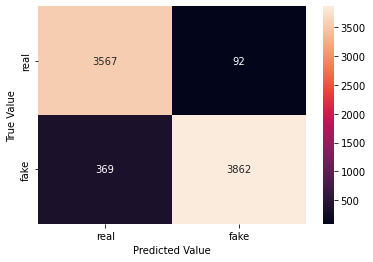



{'maxBins': 16, 'maxDepth': 10}


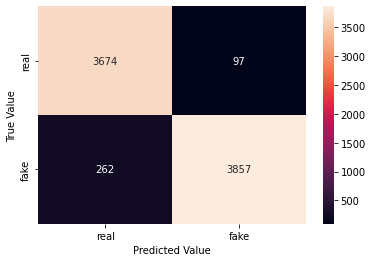



{'maxBins': 16, 'maxDepth': 20}


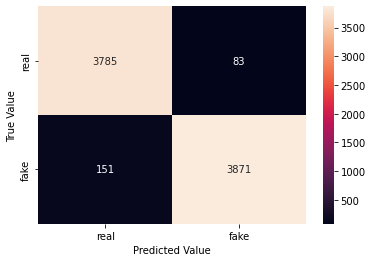



{'maxBins': 32, 'maxDepth': 5}


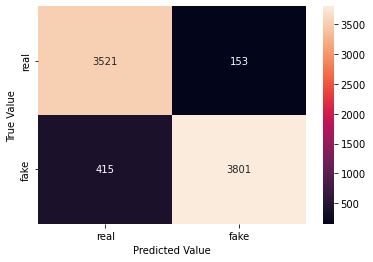



{'maxBins': 32, 'maxDepth': 7}


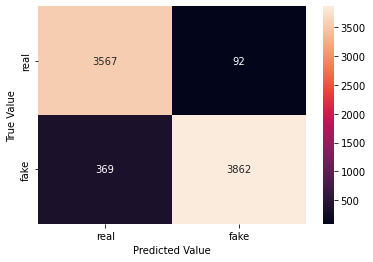



{'maxBins': 32, 'maxDepth': 10}


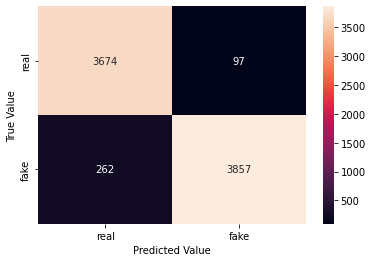



{'maxBins': 32, 'maxDepth': 20}


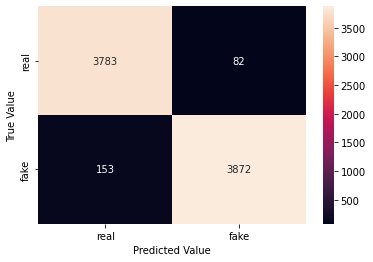



{'maxBins': 64, 'maxDepth': 5}


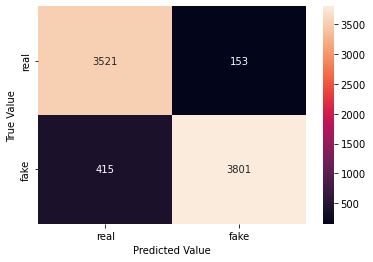



{'maxBins': 64, 'maxDepth': 7}


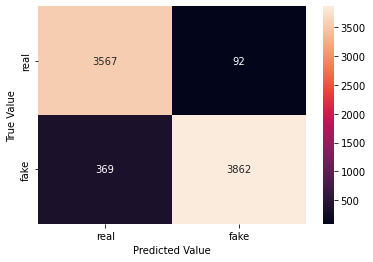



{'maxBins': 64, 'maxDepth': 10}


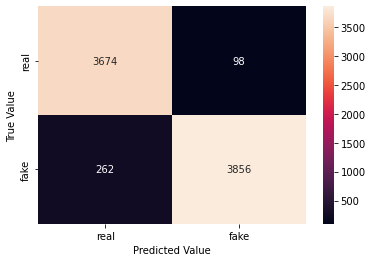



{'maxBins': 64, 'maxDepth': 20}


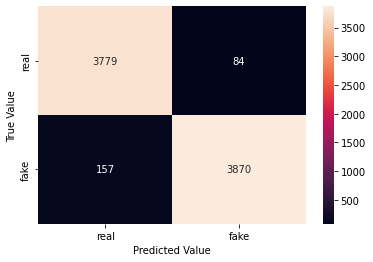

In [ ]:
# Author: Brandon Attai
# test confusion matrix for every hyperparameter combination
for l in cvModel.subModels:
    for m in l:
        predictionAndLabel = m.transform(test_df).select("categoryIndex", "prediction")
        metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))

        java_model = m._java_obj
        print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) for param in paramGrid[0]})
        plot_confusion_matrix(metrics.confusionMatrix().toArray())
        print("\n")

## Decision Tree On Original Dataset Only




precision: 0.9877982646420824
recall: 0.968110550093011
f1 score: 0.9778553214333647




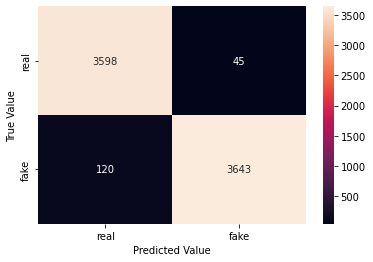

In [ ]:
# Author: Brandon Attai
#take best model from above and fit on this original dataset 
dt = dt_classifier = DecisionTreeClassifier(maxBins=32,
                                            maxDepth = 20,
                                            featuresCol= 'features_vec',\
                                            labelCol='categoryIndex').\
                                            fit(original_train_df)

predictionAndLabel = best.transform(original_test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())


{Param(parent='RandomForestClassifier_5855eb42bf3d', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_5855eb42bf3d', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16, Param(parent='RandomForestClassifier_5855eb42bf3d', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): False, Param(parent='RandomForestClassifier_5855eb42bf3d', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20}

## Decision Tree on New Dataset Only - No hyperparameter tuning



precision: 0.9603174603174603
recall: 0.8832116788321168
f1 score: 0.920152091254753




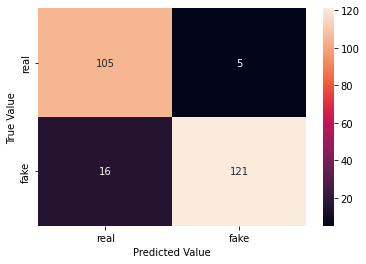

In [ ]:
# Author: Brandon Attai
#take best model from above and fit on this original dataset 
dt = dt_classifier = DecisionTreeClassifier(featuresCol= 'features_vec',\
                                            labelCol='categoryIndex').\
                                            fit(new_train_df)

predictionAndLabel = dt.transform(new_test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())

## Decision Tree on Original Dataset Only - No hyperparameter tuning


precision: 0.9644793926247288
recall: 0.9060112073357106
f1 score: 0.9343314946151825




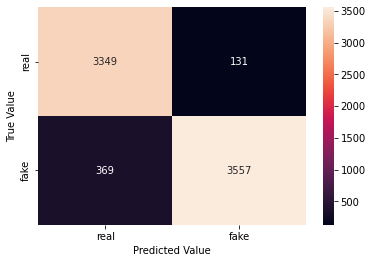

In [ ]:
# Author: Brandon Attai
#take best model from above and fit on this original dataset 
dt = dt_classifier = DecisionTreeClassifier(featuresCol= 'features_vec',\
                                            labelCol='categoryIndex').\
                                            fit(original_train_df)

predictionAndLabel = dt.transform(original_test_df).select("categoryIndex", "prediction")
metrics = MulticlassMetrics(predictionAndLabel.rdd.map(tuple))
print("precision: {}".format(metrics.precision(1.0)))
print("recall: {}".format(metrics.recall(1.0)))
print("f1 score: {}".format(metrics.fMeasure(1.0)))
print("\n")
plot_confusion_matrix(metrics.confusionMatrix().toArray())